# 0. Preparation


In [1]:
import joblib
import cv2
import numpy as np
import re
from matplotlib import pyplot as plt
from typing import Tuple, List, Dict, Optional, Any

# 1. Model Loading (OCR)


In [2]:
knn_model = joblib.load("../output/models/knn_model.pkl")
logistic_model = joblib.load("../output/models/logistic_regression_model.pkl")

# 2. Data Preprocessing


In [3]:
def preprocess_char(roi: np.ndarray) -> Optional[np.ndarray]:
    """
    Preprocess cropped ROI for model inference using
    EXACT SAME STEPS as training preprocess_digit().
    """

    # 1. ROI is already grayscale, no need for BGR2GRAY
    gray = roi.copy()

    # 2. threshold (binary inverse + Otsu)
    _, bw = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # 3. find bounding box (same as training)
    ys, xs = np.where(bw == 255)
    if len(xs) == 0 or len(ys) == 0:
        return None

    x1, x2 = xs.min(), xs.max()
    y1, y2 = ys.min(), ys.max()
    digit = bw[y1 : y2 + 1, x1 : x2 + 1]

    # 4. resize longest side to 22 px
    h, w = digit.shape
    if h > w:
        new_h, new_w = 22, int(w * (22 / h))
    else:
        new_w, new_h = 22, int(h * (22 / w))

    digit_resized = cv2.resize(digit, (new_w, new_h), interpolation=cv2.INTER_AREA)

    # 5. pad to 28x28
    top = (28 - new_h) // 2
    bottom = 28 - new_h - top
    left = (28 - new_w) // 2
    right = 28 - new_w - left

    digit_padded = cv2.copyMakeBorder(
        digit_resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=0
    )

    # 6. normalize + flatten
    digit_norm = digit_padded.astype("float32") / 255.0
    flat = digit_norm.flatten()

    return flat.reshape(1, -1)

# 3. Text Segmentation


In [4]:
def process_text_detection(
    image: np.ndarray,
) -> Tuple[
    np.ndarray, List[Tuple[int, int, int, int]], np.ndarray, np.ndarray, np.ndarray
]:
    """Your existing function - this works well"""
    original = image.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blur, 50, 150)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    dilated = cv2.dilate(edges, kernel, iterations=2)

    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    boxes = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)

        if w < 20 or h < 10:
            continue
        ratio = w / float(h)
        if ratio < 0.2 or ratio > 15:
            continue
        area = w * h
        if area < 50 or area > image.shape[0] * image.shape[1] * 0.5:
            continue

        boxes.append((x, y, w, h))
        cv2.rectangle(original, (x, y), (x + w, y + h), (0, 255, 0), 2)

    return original, boxes, gray, edges, dilated


def process_line_grouping(
    boxes: List[Tuple[int, int, int, int]], line_threshold: int = 15
) -> List[List[Tuple[int, int, int, int]]]:
    """Group boxes that are on the same line"""
    if not boxes:
        return []

    # Sort by Y position
    boxes_sorted = sorted(boxes, key=lambda box: box[1])

    lines = []
    current_line = []
    current_y = boxes_sorted[0][1]

    for box in boxes_sorted:
        x, y, w, h = box

        # Check if this box is on the same line (within threshold)
        if abs(y - current_y) <= line_threshold:
            current_line.append(box)
        else:
            # New line detected
            if current_line:
                # Sort boxes in the line by X coordinate (left to right)
                current_line_sorted = sorted(current_line, key=lambda b: b[0])
                lines.append(current_line_sorted)
            current_line = [box]
            current_y = y

    # Don't forget the last line
    if current_line:
        current_line_sorted = sorted(current_line, key=lambda b: b[0])
        lines.append(current_line_sorted)

    return lines


def merge_small_vertical_components(
    boxes: List[Tuple[int, int, int, int]],
    y_thresh: int = 10,
    x_overlap_ratio: float = 0.5,
    handle_colons: bool = True,
    colon_y_thresh: int = 35,
    colon_h_align_ratio: float = 0.6,
) -> List[Tuple[int, int, int, int]]:
    """
    Merge vertically separated components of the same character (like 'i', 'j', ':').

    Args:
        boxes: List of bounding boxes (x, y, w, h)
        y_thresh: Maximum vertical distance for general merging (i, j)
        x_overlap_ratio: Minimum horizontal overlap ratio required
        handle_colons: Whether to apply special logic for colons
        colon_y_thresh: Larger threshold for colon detection (vertical gap)
        colon_h_align_ratio: Horizontal alignment tolerance for colons

    Returns:
        List of merged bounding boxes
    """
    merged = []
    used = set()

    for i, (x1, y1, w1, h1) in enumerate(boxes):
        if i in used:
            continue

        merged_box = (x1, y1, w1, h1)
        merged_components = [i]

        # Keep searching for components to merge
        for j, (x2, y2, w2, h2) in enumerate(boxes):
            if i == j or j in used:
                continue

            # Update coordinates from current merged box
            mx, my, mw, mh = merged_box

            # Calculate vertical gap between boxes
            vertical_gap = min(abs((my + mh) - y2), abs((y2 + h2) - my))

            # Calculate horizontal overlap
            x_overlap = max(0, min(mx + mw, x2 + w2) - max(mx, x2))
            has_horizontal_overlap = x_overlap > min(mw, w2) * x_overlap_ratio

            # Check horizontal alignment (for colons)
            center_x1 = mx + mw / 2
            center_x2 = x2 + w2 / 2
            h_alignment = abs(center_x1 - center_x2) / max(mw, w2)
            is_horizontally_aligned = h_alignment < colon_h_align_ratio

            should_merge = False

            # Standard close merging (for 'i', 'j')
            if vertical_gap < y_thresh and has_horizontal_overlap:
                should_merge = True

            # Special colon handling
            if (
                handle_colons
                and vertical_gap < colon_y_thresh
                and is_horizontally_aligned
            ):
                # Check if components are small and similar in size
                area1 = mw * mh
                area2 = w2 * h2
                avg_area = (area1 + area2) / 2
                size_ratio = (
                    min(area1, area2) / max(area1, area2)
                    if max(area1, area2) > 0
                    else 0
                )

                # Both are small dots and similar size → likely colon
                if avg_area < 300 and size_ratio > 0.25:
                    should_merge = True

            if should_merge:
                # Merge into expanded bounding box
                nx = min(mx, x2)
                ny = min(my, y2)
                nw = max(mx + mw, x2 + w2) - nx
                nh = max(my + mh, y2 + h2) - ny

                merged_box = (nx, ny, nw, nh)
                merged_components.append(j)
                used.add(j)

        merged.append(merged_box)
        for comp_idx in merged_components:
            used.add(comp_idx)

    return merged


def segment_characters_grayscale(
    image_gray: np.ndarray,
    merge_vertical: bool = True,
    y_thresh: int = 10,
    x_overlap_ratio: float = 0.5,
) -> List[Tuple[int, int, int, int]]:
    """
    Segment characters from grayscale image with optional vertical merging.

    Args:
        image_gray: Grayscale input image
        merge_vertical: Whether to merge vertically separated components
        y_thresh: Vertical distance threshold for merging
        x_overlap_ratio: Horizontal overlap ratio for merging

    Returns:
        List of character bounding boxes sorted left to right
    """
    _, bw = cv2.threshold(image_gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    contours, _ = cv2.findContours(bw, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    boxes = [cv2.boundingRect(c) for c in contours]

    # Merge vertical components for characters like 'i', 'j'
    if merge_vertical and len(boxes) > 0:
        boxes = merge_small_vertical_components(boxes, y_thresh, x_overlap_ratio)

    # Sort left to right
    boxes = sorted(boxes, key=lambda b: b[0])
    return boxes


def segment_characters(
    img_bgr: np.ndarray,
    merge_vertical: bool = True,
    y_thresh: int = 10,
    x_overlap_ratio: float = 0.5,
) -> List[Tuple[int, int, int, int]]:
    """
    Segment characters from BGR image with optional vertical merging.

    Args:
        img_bgr: BGR input image
        merge_vertical: Whether to merge vertically separated components
        y_thresh: Vertical distance threshold for merging
        x_overlap_ratio: Horizontal overlap ratio for merging

    Returns:
        List of character bounding boxes sorted left to right
    """
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    _, bw = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # find contours (characters)
    contours, _ = cv2.findContours(bw, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # bounding boxes
    boxes = [cv2.boundingRect(c) for c in contours]

    # Merge vertical components for characters like 'i', 'j'
    if merge_vertical and len(boxes) > 0:
        boxes = merge_small_vertical_components(boxes, y_thresh, x_overlap_ratio)

    # sort left to right
    boxes = sorted(boxes, key=lambda b: b[0])

    return boxes

# 4. Text Extraction


Some text extraction helpers


In [5]:
def predict_char_models(roi: np.ndarray) -> Tuple[str, str]:
    """
    Run prediction using both models.
    Return a tuple: (knn_char, logistic_char)
    """
    processed = preprocess_char(roi)

    if processed is None:
        return "", ""

    # KNN prediction
    knn_pred = knn_model.predict(processed)[0]

    # Logistic regression prediction
    log_pred = logistic_model.predict(processed)[0]

    return knn_pred, log_pred


def extract_text_from_line(
    image: np.ndarray, line_boxes: List[Tuple[int, int, int, int]]
) -> Tuple[str, str]:
    # max lines for debugging
    max_lines = 2
    shown_lines = 0

    text_knn = ""
    text_logistic = ""

    for x, y, w, h in line_boxes:
        print(f"\n=== Line {shown_lines} Bounding Box: {x, y, w, h} ===")

        # crop line region
        line_roi = image[y : y + h, x : x + w]

        # convert to grayscale if needed
        if len(line_roi.shape) == 3:
            gray_line = cv2.cvtColor(line_roi, cv2.COLOR_BGR2GRAY)
        else:
            gray_line = line_roi

        # segment characters inside this line - use grayscale version
        char_boxes = segment_characters_grayscale(gray_line)

        print(f"Characters detected in line {shown_lines}: {len(char_boxes)}")

        # visualize each character
        for i, (cx, cy, cw, ch) in enumerate(char_boxes):
            char_roi = gray_line[cy : cy + ch, cx : cx + cw]

            processed = preprocess_char(char_roi)
            if processed is None:
                print(f"   Character {i}: EMPTY or INVALID")
                continue

            processed_img = (processed.reshape(28, 28) * 255).astype("uint8")

            # Predict (optional)
            pred_knn, pred_log = predict_char_models(char_roi)

            text_knn += pred_knn
            text_logistic += pred_log

            # visualize only first 2 lines
            if shown_lines < max_lines:
                fig, ax = plt.subplots(1, 2, figsize=(5, 3))

                ax[0].imshow(char_roi, cmap="gray")
                ax[0].set_title(f"Raw ROI\nBox={cx, cy, cw, ch}")
                ax[0].axis("off")

                ax[1].imshow(processed_img, cmap="gray")
                ax[1].set_title(f"Preprocessed 28×28\nKNN={pred_knn}, LR={pred_log}")
                ax[1].axis("off")

                plt.suptitle(f"Line {shown_lines + 1} - Character {i}")
                plt.show()

        shown_lines += 1

    return text_knn, text_logistic


def parse_line_by_position(line_text: str, line_number: int) -> Tuple[str, str]:
    t = line_text.lower()

    # Strong keyword-based classification
    if any(k in t for k in ["transfer berhasil", "berhasil"]):
        return "transaction_status", line_text

    if re.search(r"rp\s*\d", t):
        return "total_amount", line_text

    if any(
        m in t
        for m in [
            "wib",
            "jan",
            "feb",
            "mar",
            "apr",
            "mei",
            "jun",
            "jul",
            "agu",
            "sep",
            "okt",
            "nov",
            "des",
        ]
    ):
        return "datetime", line_text

    if "ref" in t and "id" in t:
        return "transaction_id", line_text

    if "penerima" in t:
        return "receiver_title", line_text

    # Name heuristics
    if any(prefix in t for prefix in ["sdri", "sdr", "bpk", "ibu"]):
        return "receiver_name", line_text

    if any(b in t for b in ["bni", "bca", "mandiri", "bri", "btn"]):
        return "receiver_bank", line_text

    if "sumber dana" in t:
        return "sender_title", line_text

    # Masked account
    if "***" in line_text or re.search(r"[xX]{4,}", t):
        return "sender_account", line_text

    # Detail transfer
    if "detail transfer" in t:
        return "detail_title", line_text

    # Nominal, Fee, Total lines
    if "nominal" in t:
        return "nominal_line", line_text
    if "biaya" in t:
        return "fee_line", line_text
    if t.startswith("total") or (" total " in t):
        return "total_line", line_text

    return "unknown", line_text


def extract_amount_from_text(text: str) -> Optional[int]:
    """Extract amount value from text"""
    amount_match = re.search(r"Rp\s*([\d.,]+)", text.replace(".", ""))
    if amount_match:
        amount_str = amount_match.group(1).replace(",", "")
        return int(amount_str) if amount_str.isdigit() else None
    return None


def parse_detail_line(text: str) -> Tuple[str, Optional[int]]:
    """Parse detail lines that have labels and amounts separated"""
    if "nominal" in text.lower():
        return "nominal", extract_amount_from_text(text)
    elif "biaya transaksi" in text.lower():
        return "fee", extract_amount_from_text(text)
    elif "total" in text.lower():
        return "total", extract_amount_from_text(text)
    return "unknown", None

In [6]:
def process_text_extraction(
    gray: np.ndarray, lines: List[List[Tuple[int, int, int, int]]]
) -> List[Dict[str, Any]]:
    """Step 3: Extract text from each line using both models"""
    print("\n3. Extracting text from lines...")
    lines_data = []

    for i, line_boxes in enumerate(lines):
        text_knn, text_logistic = extract_text_from_line(gray, line_boxes)

        # Skip empty lines
        if (not text_knn.strip()) and (not text_logistic.strip()):
            continue

        # Parse using BOTH outputs
        field_knn, parsed_knn = parse_line_by_position(text_knn, i)
        field_log, parsed_log = parse_line_by_position(text_logistic, i)

        lines_data.append(
            {
                "line_number": i,
                "text_knn": text_knn,
                "text_logistic": text_logistic,
                "field_knn": field_knn,
                "field_logistic": field_log,
                "boxes": line_boxes,
            }
        )

    return lines_data

# 5. Verify Authenticity


In [7]:
def process_verification(
    line_items: List[Dict[str, Any]], expected_fields: Dict[str, Any]
) -> Dict[str, Any]:
    """
    Verifies extracted receipt fields using both OCR classifiers:
    - KNN
    - Logistic Regression

    Parameters:
        line_items: list of dicts (each contains OCR results)
        expected_fields: dict defining expected values or formats

    Returns:
        dict summary of:
        - knn_verification
        - logistic_verification
        - combined_verdict
    """

    results_knn = {}
    results_logistic = {}

    # --------------------------
    # PROCESS EACH EXTRACTED FIELD
    # --------------------------
    for item in line_items:
        # Each item contains OCR outputs for both models
        field_k = item.get("field_knn")
        text_k = item.get("text_knn")

        field_l = item.get("field_logistic")
        text_l = item.get("text_logistic")

        # --------------------------
        # Store KNN result
        # --------------------------
        if field_k:
            if field_k not in results_knn:
                results_knn[field_k] = text_k

        # --------------------------
        # Store Logistic result
        # --------------------------
        if field_l:
            if field_l not in results_logistic:
                results_logistic[field_l] = text_l

    # ---------------------------------
    # VERIFICATION LOGIC
    # ---------------------------------
    knn_check = {}
    logistic_check = {}

    def check_value(expected, actual):
        """Simple comparison helper."""
        if expected is None:
            return True
        return str(expected).strip() == str(actual).strip()

    # --------------------------
    # Check KNN
    # --------------------------
    for field, expected_value in expected_fields.items():
        print("KNN verification")
        actual = results_knn.get(field)
        print(f"Actual {actual} - Expected value: {expected_value}")
        knn_check[field] = {
            "expected": expected_value,
            "actual": actual,
            "match": check_value(expected_value, actual),
        }

    # --------------------------
    # Check Logistic Regression
    # --------------------------
    for field, expected_value in expected_fields.items():
        print("Logistic regression verification")
        actual = results_logistic.get(field)
        print(f"Actual {actual} - Expected value: {expected_value}")
        logistic_check[field] = {
            "expected": expected_value,
            "actual": actual,
            "match": check_value(expected_value, actual),
        }

    # --------------------------
    # Combined final verdict
    # --------------------------
    knn_pass = all(v["match"] for v in knn_check.values())
    logistic_pass = all(v["match"] for v in logistic_check.values())

    combined = {
        "knn_pass": knn_pass,
        "logistic_pass": logistic_pass,
        "final_verdict": (
            "VALID RECEIPT" if knn_pass or logistic_pass else "POTENTIALLY FAKE"
        ),
    }

    # --------------------------
    # Return full report
    # --------------------------
    return {
        "knn_verification": knn_check,
        "logistic_verification": logistic_check,
        "combined": combined,
    }

# 6. Layout Aware Receipt Verification


Visualization function helper


In [8]:
def get_field_colors() -> Dict[str, Tuple[int, int, int]]:
    """Get color mapping for different field types"""
    return {
        "app_logo": (255, 0, 0),  # Red
        "bank_name": (0, 0, 255),  # Blue
        "transaction_status": (0, 255, 0),  # Green
        "total_amount": (255, 255, 0),  # Cyan
        "datetime": (255, 0, 255),  # Magenta
        "transaction_id": (0, 255, 255),  # Yellow
        "receiver_title": (128, 0, 128),  # Purple
        "receiver_name": (128, 128, 0),  # Olive
        "receiver_bank": (0, 128, 128),  # Teal
        "sender_title": (128, 128, 128),  # Gray
        "sender_name": (64, 64, 64),  # Dark Gray
        "sender_account": (192, 192, 192),  # Light Gray
        "detail_title": (255, 165, 0),  # Orange
        "nominal_line": (255, 192, 203),  # Pink
        "fee_line": (173, 216, 230),  # Light Blue
        "total_line": (144, 238, 144),  # Light Green
        "unknown": (0, 0, 0),  # Black
    }


def extract_layout_fingerprint(
    lines: List[List[Tuple[int, int, int, int]]], image_shape: Tuple[int, int]
) -> Dict[str, Any]:
    """
    Extract structural features from receipt layout to create a fingerprint.

    Args:
        lines: List of line segments (each containing boxes)
        image_shape: (height, width) of the image

    Returns:
        Dictionary containing layout features
    """
    if not lines:
        return {}

    img_height, img_width = image_shape

    # 1. Line distribution analysis
    line_y_positions = []
    line_heights = []
    line_widths = []
    line_x_starts = []

    for line_boxes in lines:
        if not line_boxes:
            continue

        # Get y-position of line (use first box)
        y_pos = line_boxes[0][1]
        line_y_positions.append(y_pos / img_height)  # Normalize

        # Calculate line metrics
        y_min = min(box[1] for box in line_boxes)
        y_max = max(box[1] + box[3] for box in line_boxes)
        x_min = min(box[0] for box in line_boxes)
        x_max = max(box[0] + box[2] for box in line_boxes)

        line_heights.append((y_max - y_min) / img_height)
        line_widths.append((x_max - x_min) / img_width)
        line_x_starts.append(x_min / img_width)

    # 2. Vertical spacing analysis
    line_gaps = []
    for i in range(len(line_y_positions) - 1):
        gap = line_y_positions[i + 1] - line_y_positions[i]
        line_gaps.append(gap)

    # 3. Horizontal alignment analysis
    alignment_variance = np.var(line_x_starts) if line_x_starts else 0

    # 4. Density zones (top, middle, bottom)
    top_zone_lines = sum(1 for y in line_y_positions if y < 0.33)
    middle_zone_lines = sum(1 for y in line_y_positions if 0.33 <= y < 0.67)
    bottom_zone_lines = sum(1 for y in line_y_positions if y >= 0.67)

    total_lines = len(line_y_positions)
    zone_distribution = [
        top_zone_lines / total_lines if total_lines > 0 else 0,
        middle_zone_lines / total_lines if total_lines > 0 else 0,
        bottom_zone_lines / total_lines if total_lines > 0 else 0,
    ]

    # 5. Width pattern analysis
    narrow_lines = sum(1 for w in line_widths if w < 0.5)
    medium_lines = sum(1 for w in line_widths if 0.5 <= w < 0.8)
    wide_lines = sum(1 for w in line_widths if w >= 0.8)

    width_distribution = [
        narrow_lines / total_lines if total_lines > 0 else 0,
        medium_lines / total_lines if total_lines > 0 else 0,
        wide_lines / total_lines if total_lines > 0 else 0,
    ]

    return {
        "num_lines": len(lines),
        "avg_line_height": np.mean(line_heights) if line_heights else 0,
        "std_line_height": np.std(line_heights) if line_heights else 0,
        "avg_line_width": np.mean(line_widths) if line_widths else 0,
        "std_line_width": np.std(line_widths) if line_widths else 0,
        "avg_line_gap": np.mean(line_gaps) if line_gaps else 0,
        "std_line_gap": np.std(line_gaps) if line_gaps else 0,
        "alignment_variance": alignment_variance,
        "zone_distribution": zone_distribution,
        "width_distribution": width_distribution,
        "line_y_positions": line_y_positions,
    }


def get_template_layout_fingerprint() -> Dict[str, Any]:
    """
    Define the expected layout fingerprint for valid receipts.
    These values should be calibrated based on your genuine receipt samples.

    Returns:
        Dictionary containing expected layout features with acceptable ranges
    """
    return {
        "num_lines": {"min": 10, "max": 20, "ideal": 15},
        "avg_line_height": {"min": 0.02, "max": 0.08, "ideal": 0.04},
        "avg_line_width": {"min": 0.5, "max": 0.95, "ideal": 0.75},
        "avg_line_gap": {"min": 0.02, "max": 0.10, "ideal": 0.05},
        "alignment_variance": {"max": 0.05},  # Lines should be mostly aligned
        # Zone distribution: [top%, middle%, bottom%]
        # Expected: more content in top and middle sections
        "zone_distribution": {
            "top": {"min": 0.2, "max": 0.5},
            "middle": {"min": 0.3, "max": 0.6},
            "bottom": {"min": 0.1, "max": 0.4},
        },
        # Width distribution: [narrow%, medium%, wide%]
        "width_distribution": {
            "narrow": {"max": 0.3},  # Few narrow lines
            "medium": {"min": 0.2, "max": 0.6},
            "wide": {"min": 0.3, "max": 0.8},  # Many wide lines
        },
    }


def calculate_layout_similarity(
    detected: Dict[str, Any], template: Dict[str, Any]
) -> Dict[str, Any]:
    """
    Calculate similarity score between detected layout and template.

    Args:
        detected: Extracted layout fingerprint from image
        template: Expected layout fingerprint

    Returns:
        Dictionary containing similarity scores and detailed analysis
    """
    scores = {}
    violations = []

    # 1. Number of lines check
    num_lines = detected.get("num_lines", 0)
    if template["num_lines"]["min"] <= num_lines <= template["num_lines"]["max"]:
        scores["num_lines"] = 1.0
    else:
        scores["num_lines"] = 0.0
        violations.append(
            f"Line count {num_lines} outside range [{template['num_lines']['min']}, {template['num_lines']['max']}]"
        )

    # 2. Average line height check
    avg_height = detected.get("avg_line_height", 0)
    if (
        template["avg_line_height"]["min"]
        <= avg_height
        <= template["avg_line_height"]["max"]
    ):
        scores["avg_line_height"] = 1.0
    else:
        scores["avg_line_height"] = 0.0
        violations.append(
            f"Average line height {avg_height:.3f} outside expected range"
        )

    # 3. Average line width check
    avg_width = detected.get("avg_line_width", 0)
    if (
        template["avg_line_width"]["min"]
        <= avg_width
        <= template["avg_line_width"]["max"]
    ):
        scores["avg_line_width"] = 1.0
    else:
        scores["avg_line_width"] = 0.0
        violations.append(f"Average line width {avg_width:.3f} outside expected range")

    # 4. Line spacing consistency
    avg_gap = detected.get("avg_line_gap", 0)
    if template["avg_line_gap"]["min"] <= avg_gap <= template["avg_line_gap"]["max"]:
        scores["avg_line_gap"] = 1.0
    else:
        scores["avg_line_gap"] = 0.0
        violations.append(f"Line spacing {avg_gap:.3f} inconsistent with template")

    # 5. Alignment check
    alignment_var = detected.get("alignment_variance", 0)
    if alignment_var <= template["alignment_variance"]["max"]:
        scores["alignment"] = 1.0
    else:
        scores["alignment"] = 0.0
        violations.append(f"Poor alignment detected (variance: {alignment_var:.3f})")

    # 6. Zone distribution check
    zone_dist = detected.get("zone_distribution", [0, 0, 0])
    zone_score = 0
    zone_checks = 0

    zones = ["top", "middle", "bottom"]
    for i, zone in enumerate(zones):
        zone_checks += 1
        zone_val = zone_dist[i]
        zone_template = template["zone_distribution"][zone]

        if zone_template["min"] <= zone_val <= zone_template["max"]:
            zone_score += 1
        else:
            violations.append(
                f"{zone.capitalize()} zone density {zone_val:.2f} outside [{zone_template['min']}, {zone_template['max']}]"
            )

    scores["zone_distribution"] = zone_score / zone_checks if zone_checks > 0 else 0

    # 7. Width distribution check
    width_dist = detected.get("width_distribution", [0, 0, 0])
    width_score = 0
    width_checks = 0

    width_types = ["narrow", "medium", "wide"]
    for i, width_type in enumerate(width_types):
        width_checks += 1
        width_val = width_dist[i]
        width_template = template["width_distribution"][width_type]

        if "min" in width_template and "max" in width_template:
            if width_template["min"] <= width_val <= width_template["max"]:
                width_score += 1
            else:
                violations.append(
                    f"{width_type.capitalize()} lines ratio {width_val:.2f} outside expected range"
                )
        elif "max" in width_template:
            if width_val <= width_template["max"]:
                width_score += 1
            else:
                violations.append(f"Too many {width_type} lines: {width_val:.2f}")

    scores["width_distribution"] = width_score / width_checks if width_checks > 0 else 0

    # Calculate overall similarity score (weighted average)
    weights = {
        "num_lines": 0.20,
        "avg_line_height": 0.10,
        "avg_line_width": 0.10,
        "avg_line_gap": 0.10,
        "alignment": 0.15,
        "zone_distribution": 0.20,
        "width_distribution": 0.15,
    }

    overall_score = sum(scores[key] * weights[key] for key in scores.keys())

    return {
        "overall_score": overall_score,
        "detailed_scores": scores,
        "violations": violations,
        "is_similar": overall_score >= 0.65,  # Threshold: 65% similarity required
    }


def validate_layout_structure(
    lines: List[List[Tuple[int, int, int, int]]],
    image_shape: Tuple[int, int],
    similarity_threshold: float = 0.65,
) -> Dict[str, Any]:
    """
    Validate if the detected layout structure matches the expected receipt template.

    Args:
        lines: List of line segments
        image_shape: (height, width) of the image
        similarity_threshold: Minimum similarity score to pass (0.0 to 1.0)

    Returns:
        Dictionary containing validation result and detailed analysis
    """
    # Extract layout fingerprint from detected lines
    detected_fingerprint = extract_layout_fingerprint(lines, image_shape)

    # Get expected template fingerprint
    template_fingerprint = get_template_layout_fingerprint()

    # Calculate similarity
    similarity_result = calculate_layout_similarity(
        detected_fingerprint, template_fingerprint
    )

    is_valid = similarity_result["is_similar"]
    overall_score = similarity_result["overall_score"]

    validation_result = {
        "is_valid": is_valid,
        "similarity_score": overall_score,
        "threshold": similarity_threshold,
        "detected_fingerprint": detected_fingerprint,
        "template_fingerprint": template_fingerprint,
        "detailed_scores": similarity_result["detailed_scores"],
        "violations": similarity_result["violations"],
        "reason": "",
    }

    if not is_valid:
        validation_result["reason"] = (
            f"Layout structure mismatch (similarity: {overall_score:.1%}). This receipt has a different layout than expected. Likely FAKE or wrong receipt type."
        )
        if similarity_result["violations"]:
            validation_result["reason"] += (
                f"\nKey violations: {'; '.join(similarity_result['violations'][:3])}"
            )
    else:
        validation_result["reason"] = (
            f"Layout structure matches expected template (similarity: {overall_score:.1%})."
        )

    return validation_result


def validate_line_count(
    lines: List[List[Tuple[int, int, int, int]]],
    min_lines: int = 10,
    max_lines: int = 20,
) -> Dict[str, Any]:
    """
    Validate if the number of detected line segments is within acceptable range.
    Receipts with too many or too few lines are likely fake/edited.

    Args:
        lines: List of line segments (each containing boxes)
        min_lines: Minimum expected line count for a valid receipt
        max_lines: Maximum expected line count for a valid receipt

    Returns:
        Dictionary containing validation result and details
    """
    num_lines = len(lines)
    is_valid = min_lines <= num_lines <= max_lines

    validation_result = {
        "is_valid": is_valid,
        "detected_lines": num_lines,
        "expected_range": (min_lines, max_lines),
        "reason": "",
    }

    if num_lines < min_lines:
        validation_result["reason"] = (
            f"Too few lines detected ({num_lines}). Missing critical receipt fields. Likely FAKE or incomplete image."
        )
    elif num_lines > max_lines:
        validation_result["reason"] = (
            f"Too many lines detected ({num_lines}). Extra content added. Likely FAKE or edited image."
        )
    else:
        validation_result["reason"] = (
            f"Line count ({num_lines}) is within acceptable range."
        )

    return validation_result


def display_verification_results(verification: Dict[str, Any]) -> None:
    """Step 5: Display verification results in console"""
    print("\n=== VERIFICATION RESULT ===")

    # # Display line count validation if present
    # if "line_validation" in verification:
    #     line_val = verification["line_validation"]
    #     print("\n--- Line Count Validation ---")
    #     print(f"Detected Lines  : {line_val['detected_lines']}")
    #     print(
    #         f"Expected Range  : {line_val['expected_range'][0]} - {line_val['expected_range'][1]}"
    #     )
    #     print(f"Status          : {'PASS' if line_val['is_valid'] else 'FAIL'}")
    #     print(f"Reason          : {line_val['reason']}")

    #     if not line_val["is_valid"]:
    #         print("\n⚠️  EARLY DETECTION: Receipt is FAKE based on line count!")
    #         return

    # Display layout structure validation if present
    if "layout_validation" in verification:
        layout_val = verification["layout_validation"]
        print("\n--- Layout Structure Validation ---")
        print(f"Similarity Score: {layout_val['similarity_score']:.1%}")
        print(f"Threshold       : {layout_val['threshold']:.1%}")
        print(f"Status          : {'PASS' if layout_val['is_valid'] else 'FAIL'}")
        print(f"Reason          : {layout_val['reason']}")

        # Show detailed scores
        if layout_val.get("detailed_scores"):
            print("\nDetailed Scores:")
            for metric, score in layout_val["detailed_scores"].items():
                status = "✓" if score >= 0.5 else "✗"
                print(f"  {status} {metric}: {score:.1%}")

        if not layout_val["is_valid"]:
            print("\n⚠️  EARLY DETECTION: Receipt is FAKE based on layout structure!")
            return

    print(
        f"KNN Verdict     : {'PASS' if verification['combined']['knn_pass'] else 'FAIL'}"
    )
    print(
        f"Logistic Verdict: {'PASS' if verification['combined']['logistic_pass'] else 'FAIL'}"
    )
    print(f"FINAL VERDICT   : {verification['combined']['final_verdict']}")

    # Optional reporting of matches per field
    print("\n--- KNN Field Checks ---")
    for field, info in verification["knn_verification"].items():
        print(
            f"{field}: expected={info['expected']} | actual={info['actual']} | match={info['match']}"
        )

    print("\n--- Logistic Field Checks ---")
    for field, info in verification["logistic_verification"].items():
        print(
            f"{field}: expected={info['expected']} | actual={info['actual']} | match={info['match']}"
        )


def create_legend_image(lines_data: List[Dict[str, Any]]) -> np.ndarray:
    """Create legend image showing detected field types"""
    colors = get_field_colors()
    legend_img = np.ones((400, 400, 3), dtype=np.uint8) * 255
    y_offset = 30

    for field_type, color in colors.items():
        if any(field_type == line["field_knn"] for line in lines_data):
            cv2.putText(
                legend_img,
                field_type,
                (10, y_offset),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.4,
                color,
                1,
            )
            y_offset += 20

    return legend_img


def visualize_results(
    image: np.ndarray,
    result_img: np.ndarray,
    annotated_img: np.ndarray,
    lines_data: List[Dict[str, Any]],
) -> None:
    """Step 6: Create and display visualization"""
    plt.figure(figsize=(20, 10))

    plt.subplot(2, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(2, 2, 2)
    plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
    plt.title("Text Detection")
    plt.axis("off")

    plt.subplot(2, 2, 3)
    plt.imshow(cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB))
    plt.title("Layout Analysis")
    plt.axis("off")

    plt.subplot(2, 2, 4)
    legend_img = create_legend_image(lines_data)
    plt.imshow(cv2.cvtColor(legend_img, cv2.COLOR_BGR2RGB))
    plt.title("Detected Field Types")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

Anotation helper


In [9]:
def create_annotated_image(
    image: np.ndarray, lines_data: List[Dict[str, Any]], verification: Dict[str, Any]
) -> np.ndarray:
    """Create annotated image with bounding boxes and labels"""
    annotated_img = image.copy()
    colors = get_field_colors()

    # Draw annotated boxes
    for line_data in lines_data:
        field_type = line_data["field_knn"]
        color = colors.get(field_type, (0, 0, 0))

        for box in line_data["boxes"]:
            x, y, w, h = box
            cv2.rectangle(annotated_img, (x, y), (x + w, y + h), color, 2)

        # Add field type label using first box in line
        if line_data["boxes"]:
            x, y, w, h = line_data["boxes"][0]
            label = line_data["field_knn"]
            cv2.putText(
                annotated_img,
                label,
                (x, y - 10),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5,
                color,
                2,
            )

    # Add final result to image
    final_result = verification["combined"]["final_verdict"]
    knn_pass = verification["combined"]["knn_pass"]
    log_pass = verification["combined"]["logistic_pass"]

    confidence = int((knn_pass + log_pass) / 2 * 100)
    result_text = f"Result: {final_result} ({confidence}%)"

    cv2.putText(
        annotated_img, result_text, (20, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 3
    )

    return annotated_img

Layout aware receipt verification


In [10]:
def layout_aware_receipt_verification(
    image_path: str, expected_amount: Optional[Dict[str, Any]] = None
) -> Tuple[Dict[str, Any], List[Dict[str, Any]]]:
    """Complete pipeline with layout awareness"""
    print("=== LAYOUT-AWARE RECEIPT VERIFICATION ===")

    # Load and validate image
    image = cv2.imread(image_path)
    if image is None:
        return {}, []

    # Step 1: Detect text regions
    result_img, boxes, gray, edges, dilated = process_text_detection(image)

    # Step 2: Group boxes by lines
    lines = process_line_grouping(boxes, line_threshold=15)

    # Step 2.5: EARLY VALIDATION - Check line count
    line_validation = validate_line_count(lines, min_lines=15, max_lines=15)

    if not line_validation["is_valid"]:
        # Create early fake detection result
        verification = {
            "line_validation": line_validation,
            "combined": {
                "knn_pass": False,
                "logistic_pass": False,
                "final_verdict": "FAKE RECEIPT - Invalid line count",
            },
            "knn_verification": {},
            "logistic_verification": {},
            "early_detection": True,
        }

        # Display results
        display_verification_results(verification)

        # Create simple annotated image showing fake detection
        annotated_img = image.copy()
        cv2.putText(
            annotated_img,
            "FAKE RECEIPT DETECTED!",
            (20, 30),
            cv2.FONT_HERSHEY_SIMPLEX,
            1,
            (0, 0, 255),  # Red color
            3,
        )
        cv2.putText(
            annotated_img,
            line_validation["reason"],
            (20, 70),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.6,
            (0, 0, 255),
            2,
        )

        visualize_results(image, result_img, annotated_img, [])

        return verification, []

    # Step 2.6: ADVANCED VALIDATION - Check layout structure
    layout_validation = validate_layout_structure(
        lines, image_shape=(image.shape[0], image.shape[1]), similarity_threshold=0.65
    )

    if not layout_validation["is_valid"]:
        # Create early fake detection result
        verification = {
            "line_validation": line_validation,
            "layout_validation": layout_validation,
            "combined": {
                "knn_pass": False,
                "logistic_pass": False,
                "final_verdict": "FAKE RECEIPT - Layout structure mismatch",
            },
            "knn_verification": {},
            "logistic_verification": {},
            "early_detection": True,
        }

        # Display results
        display_verification_results(verification)

        # Create annotated image showing layout mismatch
        annotated_img = image.copy()
        cv2.putText(
            annotated_img,
            "FAKE RECEIPT DETECTED!",
            (20, 30),
            cv2.FONT_HERSHEY_SIMPLEX,
            1,
            (0, 0, 255),
            3,
        )
        cv2.putText(
            annotated_img,
            f"Layout Similarity: {layout_validation['similarity_score']:.1%}",
            (20, 70),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.6,
            (0, 0, 255),
            2,
        )
        cv2.putText(
            annotated_img,
            "Different layout structure detected!",
            (20, 100),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            (0, 0, 255),
            2,
        )

        visualize_results(image, result_img, annotated_img, [])

        return verification, []

    # Step 3: Extract text from each line
    lines_data = process_text_extraction(gray, lines)

    # Step 4: Verify authenticity
    verification = process_verification(lines_data, expected_amount)

    # Add line validation to verification results
    verification["line_validation"] = line_validation
    verification["layout_validation"] = layout_validation
    verification["early_detection"] = False

    # Step 5: Display results
    display_verification_results(verification)

    # Step 6: Create visualization
    annotated_img = create_annotated_image(image, lines_data, verification)
    visualize_results(image, result_img, annotated_img, lines_data)

    return verification, lines_data

# 7. Testing


=== LAYOUT-AWARE RECEIPT VERIFICATION ===

3. Extracting text from lines...

=== Line 0 Bounding Box: (330, 83, 420, 142) ===
Characters detected in line 0: 8


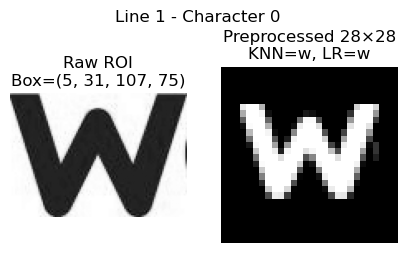

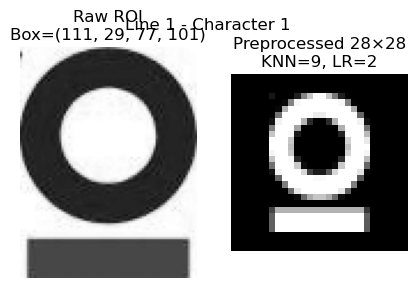

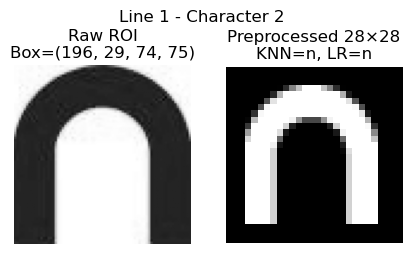

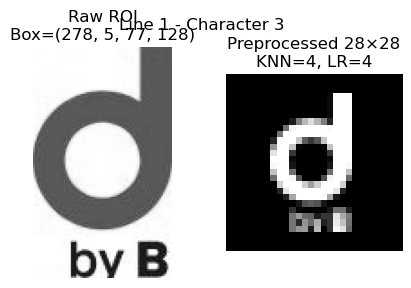

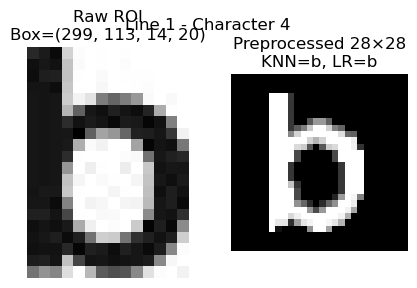

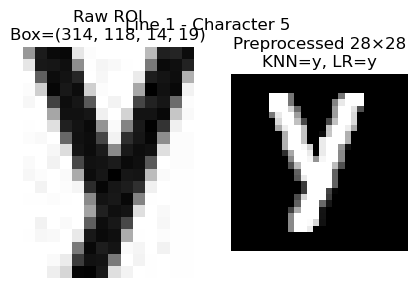

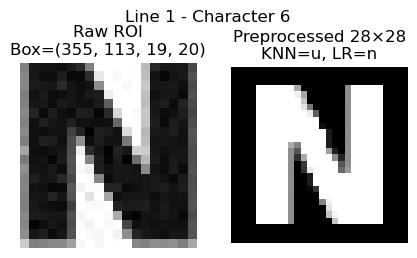

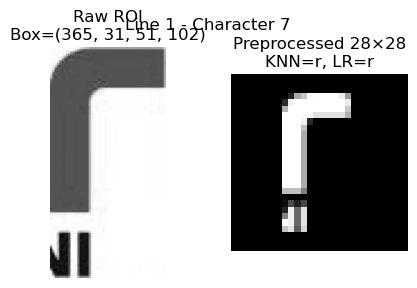


=== Line 0 Bounding Box: (341, 295, 201, 45) ===
Characters detected in line 0: 8


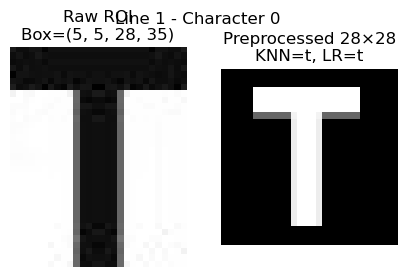

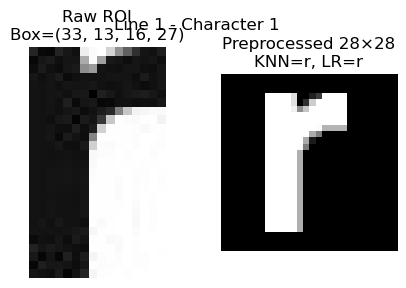

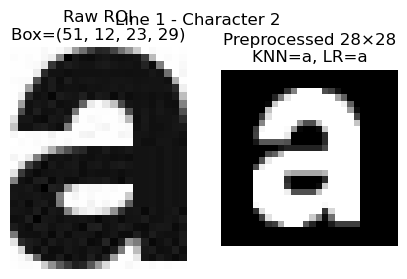

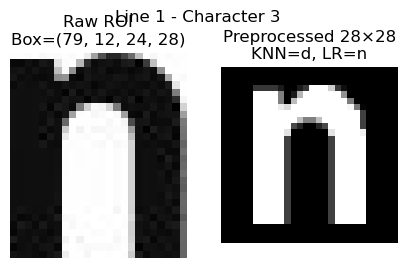

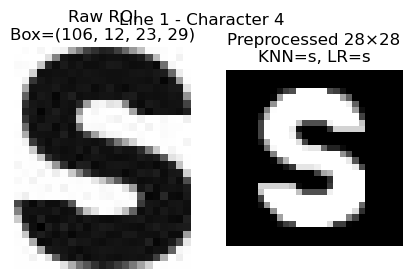

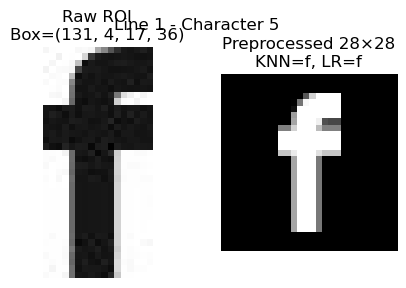

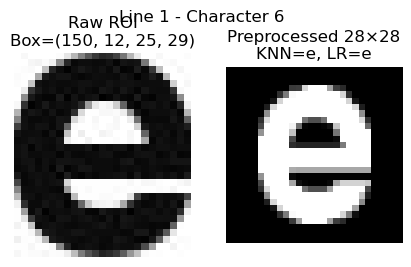

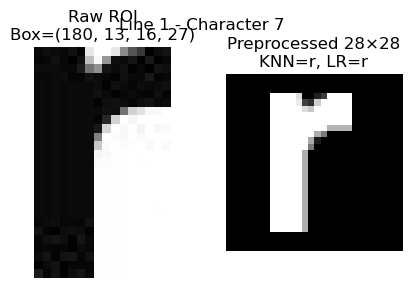


=== Line 1 Bounding Box: (548, 293, 189, 47) ===
Characters detected in line 1: 8


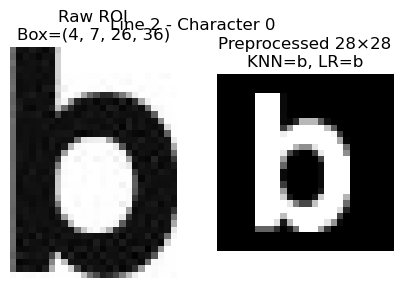

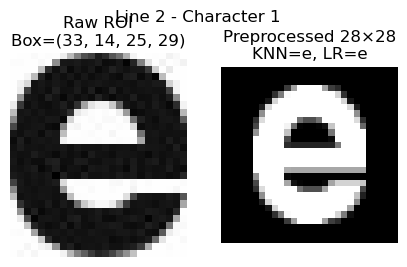

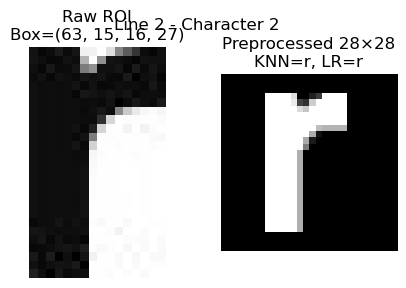

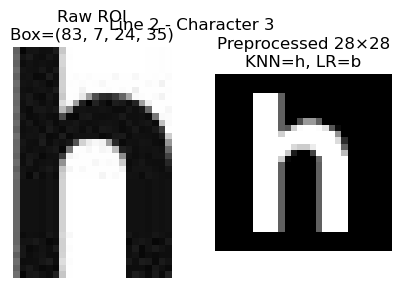

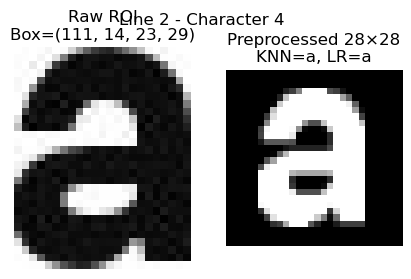

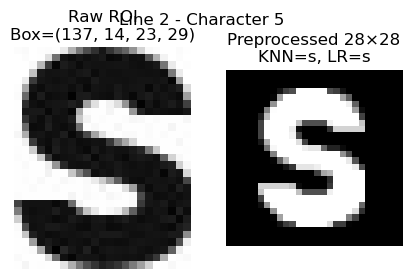

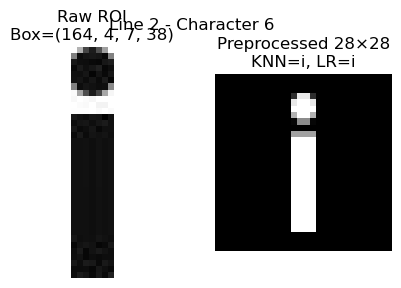

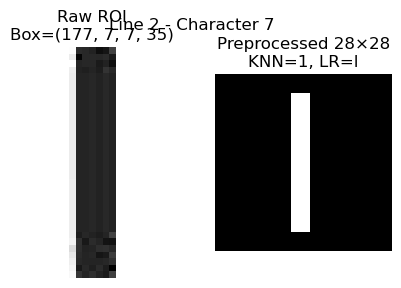


=== Line 0 Bounding Box: (367, 406, 349, 68) ===
Characters detected in line 0: 9


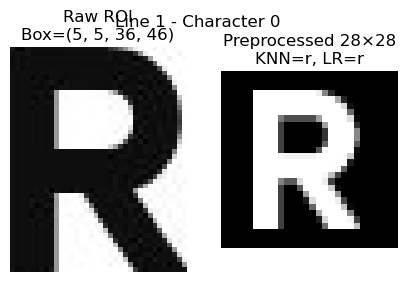

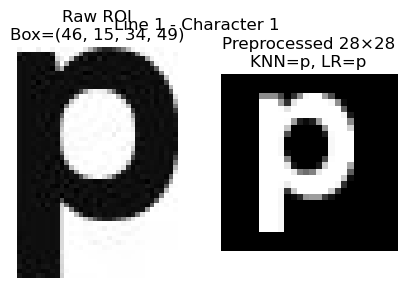

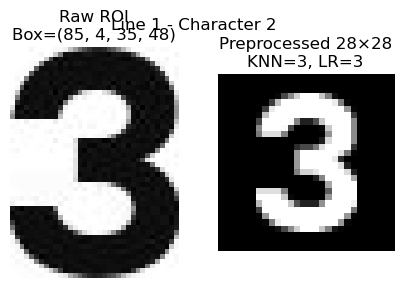

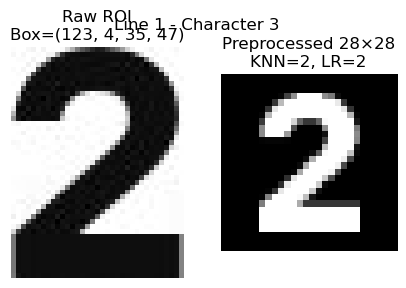

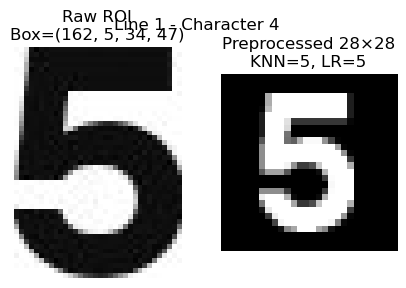

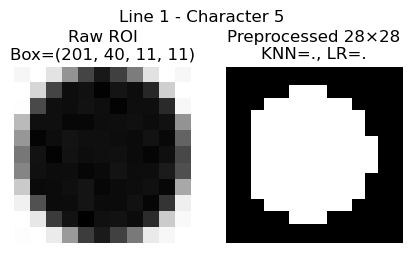

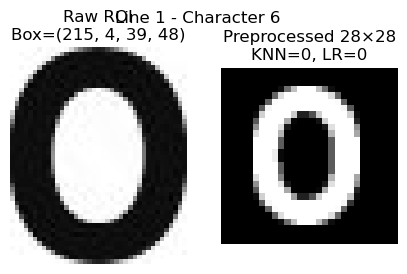

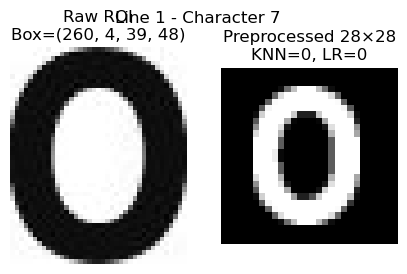

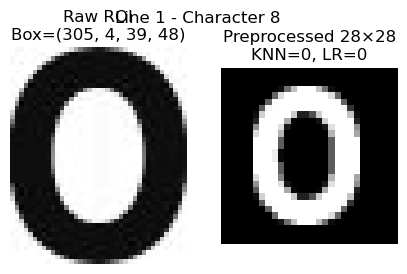


=== Line 0 Bounding Box: (295, 529, 53, 36) ===
Characters detected in line 0: 2


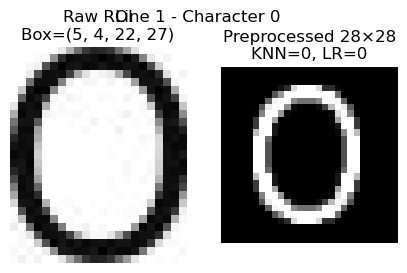

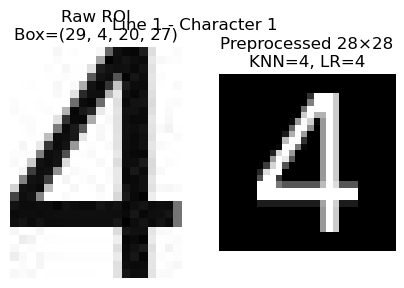


=== Line 1 Bounding Box: (351, 528, 73, 37) ===
Characters detected in line 1: 3


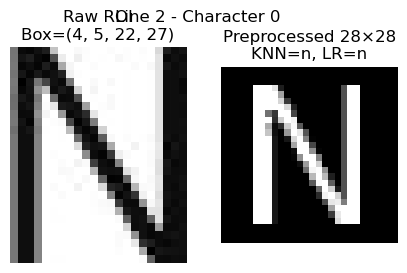

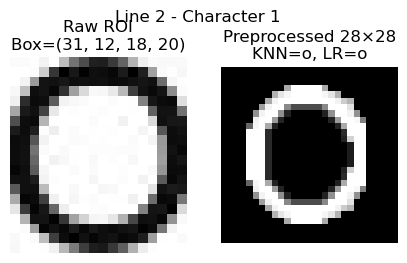

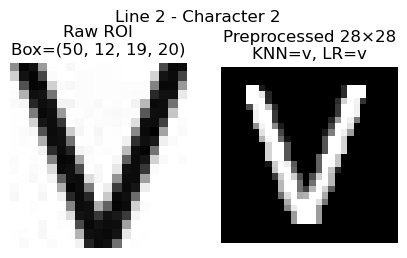


=== Line 2 Bounding Box: (426, 528, 92, 37) ===
Characters detected in line 2: 4

=== Line 3 Bounding Box: (543, 528, 132, 37) ===
Characters detected in line 3: 8

=== Line 4 Bounding Box: (676, 528, 76, 37) ===
Characters detected in line 4: 3

=== Line 0 Bounding Box: (274, 582, 62, 37) ===
Characters detected in line 0: 3


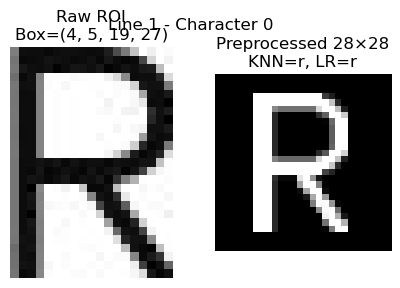

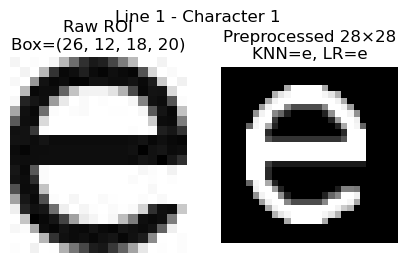

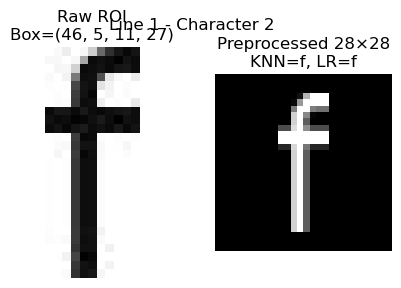


=== Line 1 Bounding Box: (339, 582, 47, 37) ===
Characters detected in line 1: 3


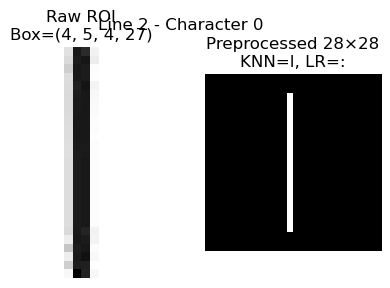

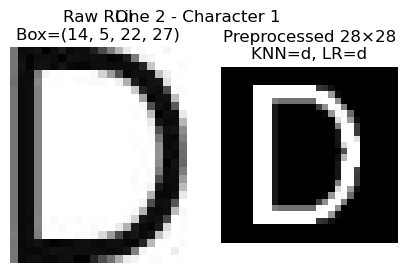

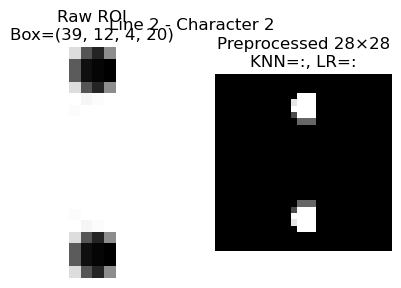


=== Line 2 Bounding Box: (390, 582, 421, 37) ===
Characters detected in line 2: 20

=== Line 0 Bounding Box: (64, 675, 174, 39) ===
Characters detected in line 0: 8


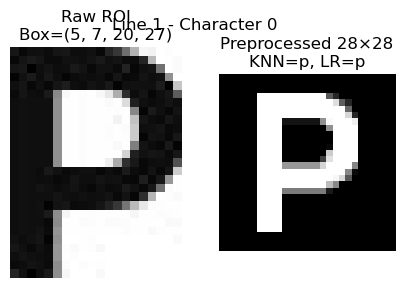

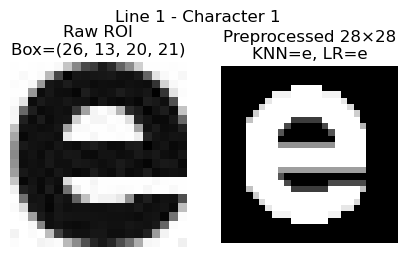

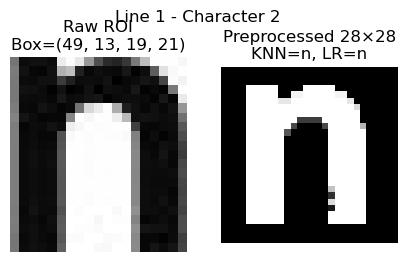

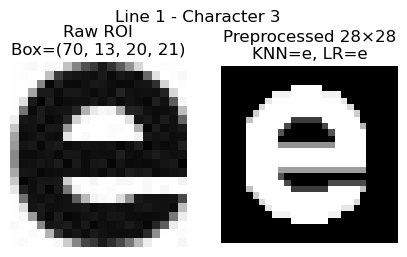

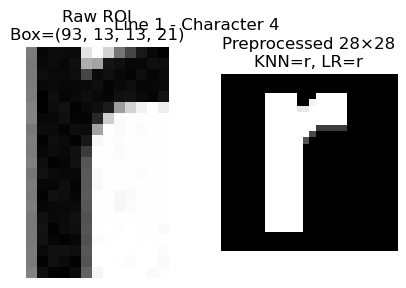

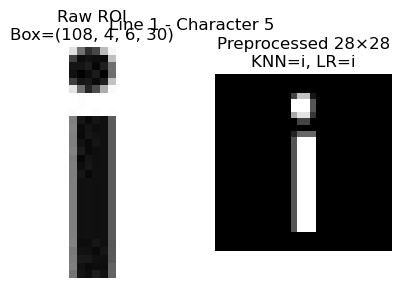

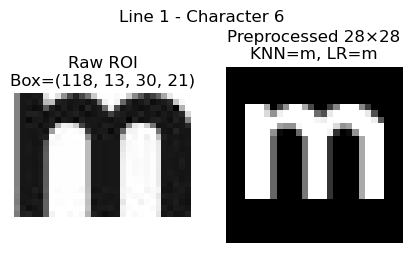

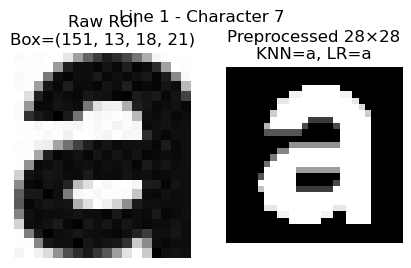


=== Line 0 Bounding Box: (63, 764, 70, 37) ===
Characters detected in line 0: 4


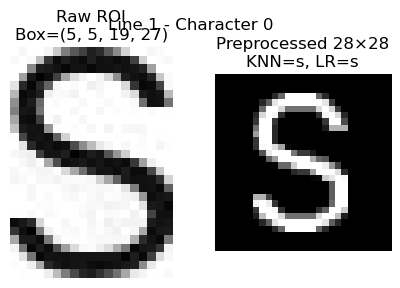

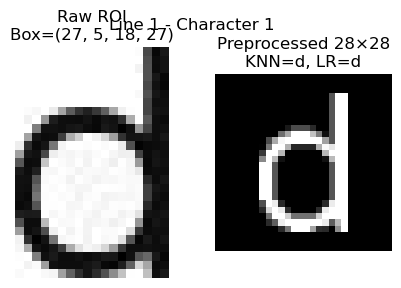

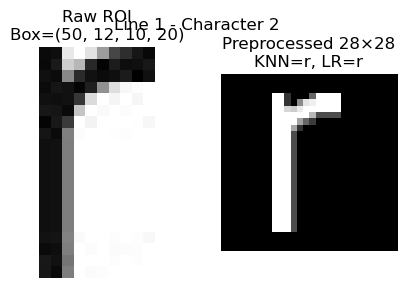

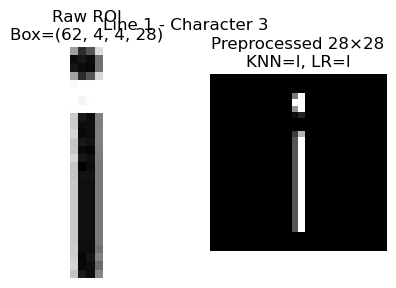


=== Line 1 Bounding Box: (138, 764, 62, 37) ===
Characters detected in line 1: 3


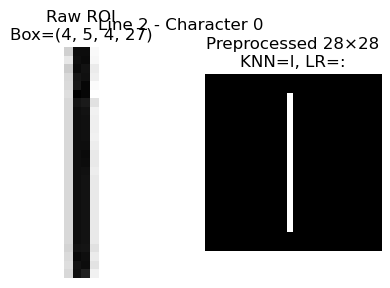

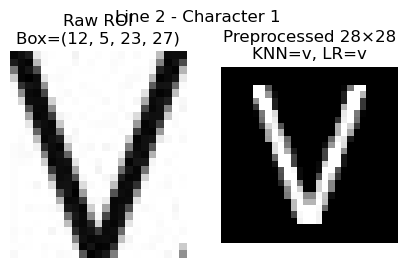

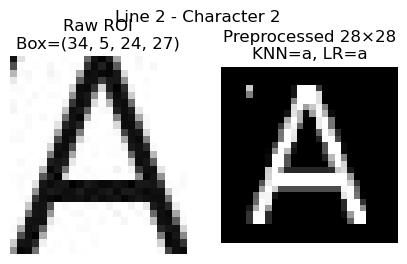


=== Line 2 Bounding Box: (203, 764, 177, 37) ===
Characters detected in line 2: 8

=== Line 0 Bounding Box: (65, 829, 65, 37) ===
Characters detected in line 0: 3


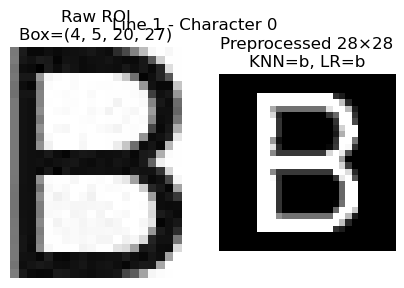

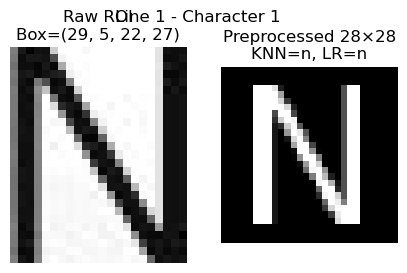

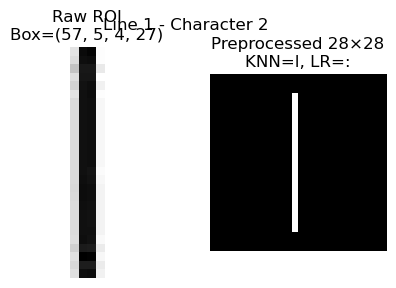


=== Line 1 Bounding Box: (158, 829, 212, 37) ===
Characters detected in line 1: 10


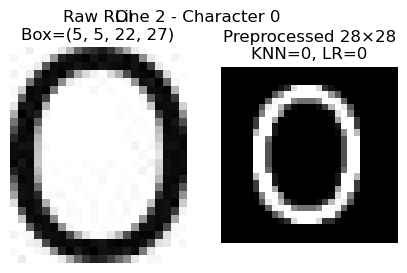

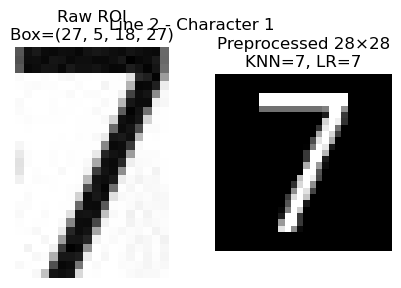

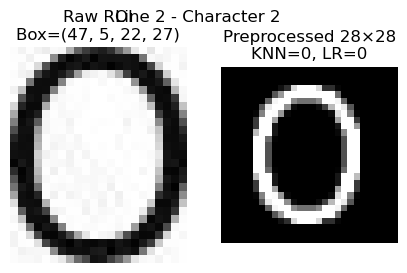

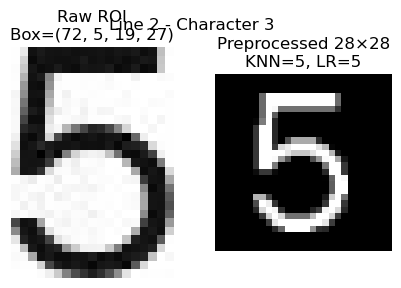

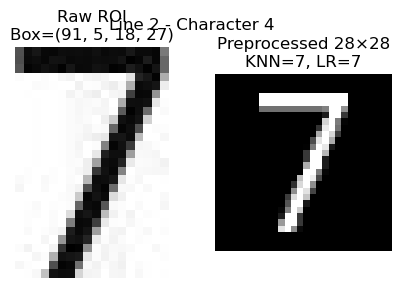

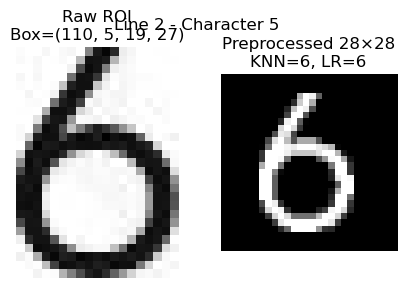

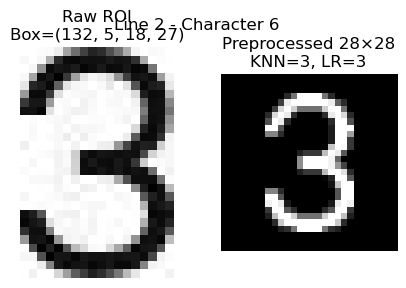

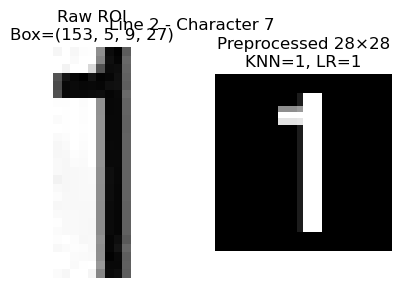

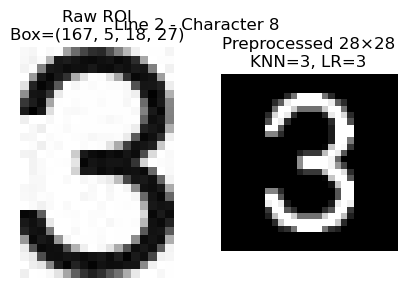

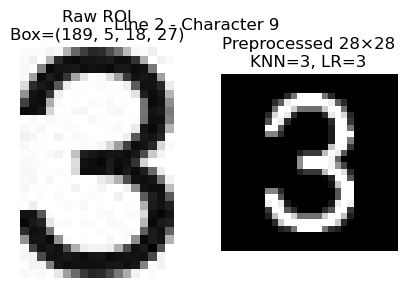


=== Line 0 Bounding Box: (63, 925, 150, 35) ===
Characters detected in line 0: 6


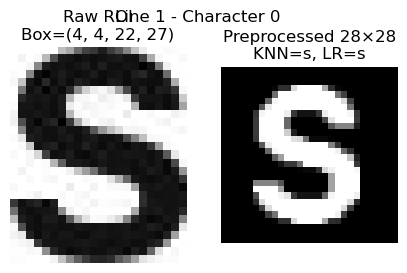

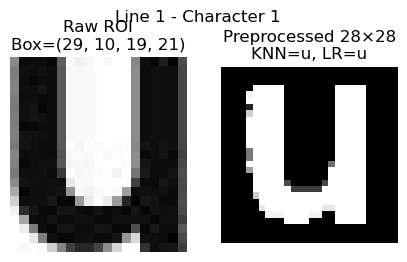

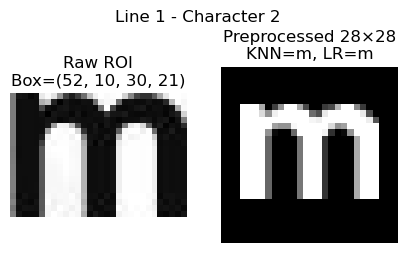

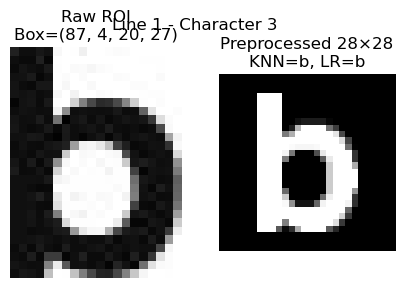

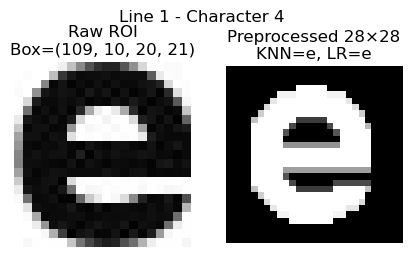

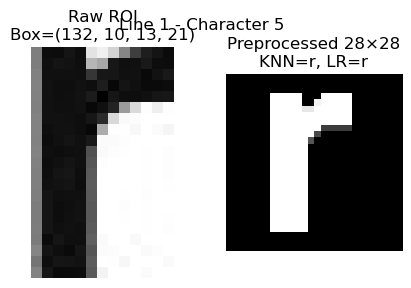


=== Line 1 Bounding Box: (214, 925, 94, 35) ===
Characters detected in line 1: 4


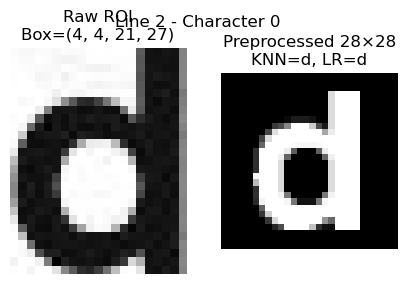

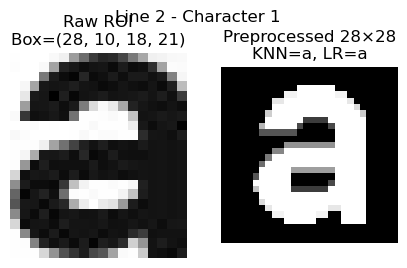

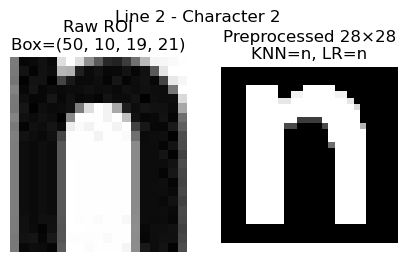

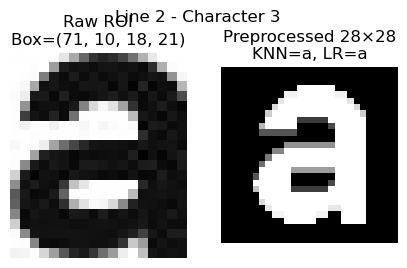


=== Line 0 Bounding Box: (65, 1011, 231, 37) ===
Characters detected in line 0: 8


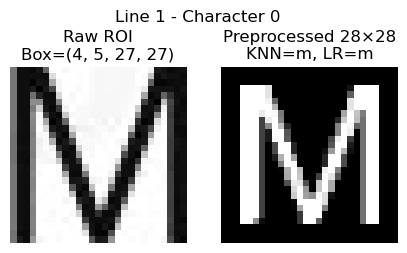

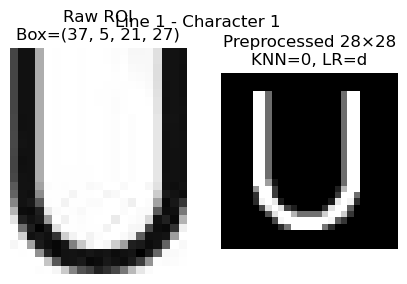

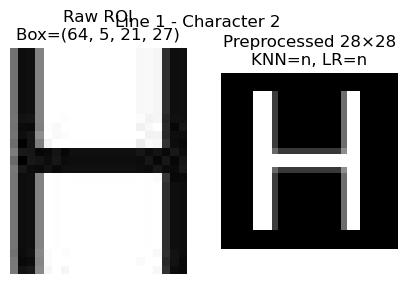

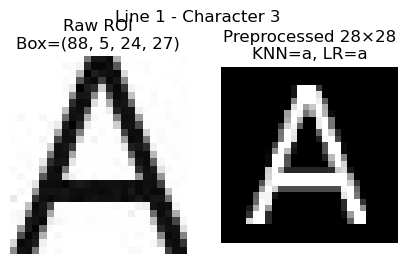

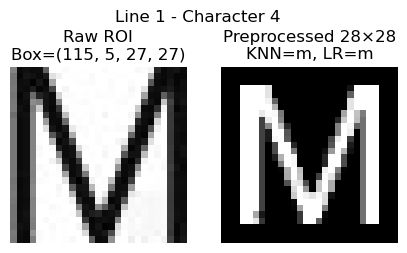

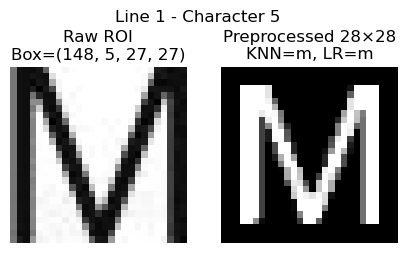

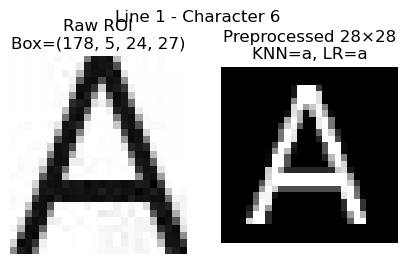

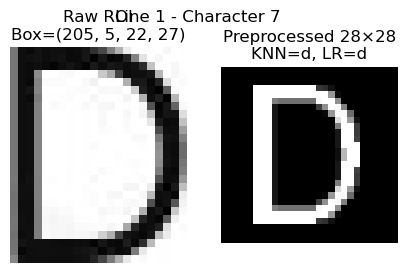


=== Line 1 Bounding Box: (300, 1011, 113, 37) ===
Characters detected in line 1: 5


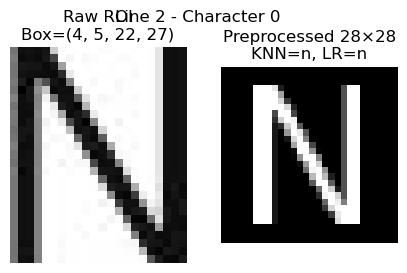

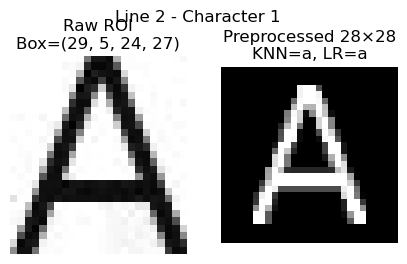

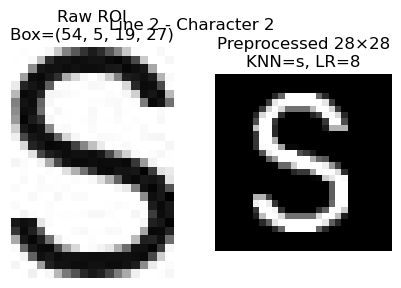

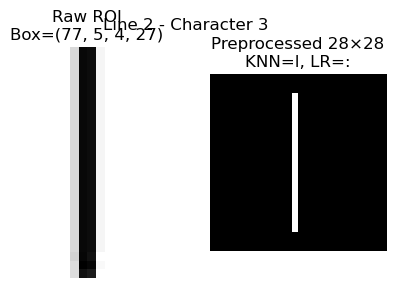

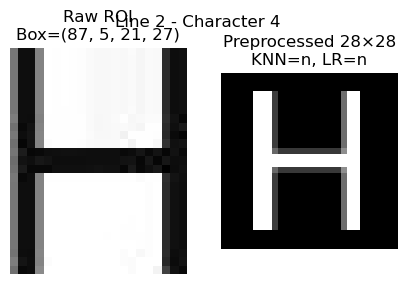


=== Line 0 Bounding Box: (63, 1076, 195, 37) ===
Characters detected in line 0: 10


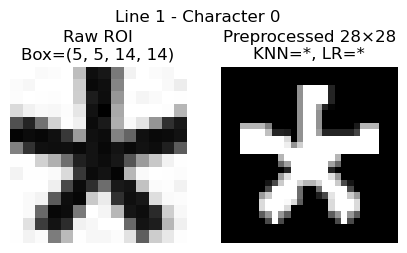

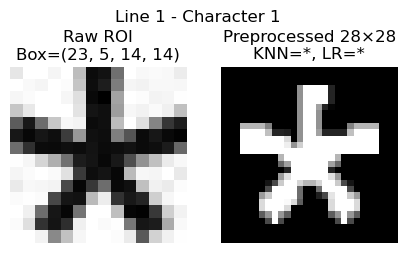

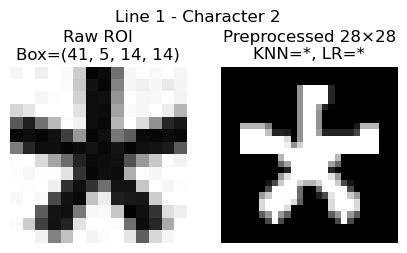

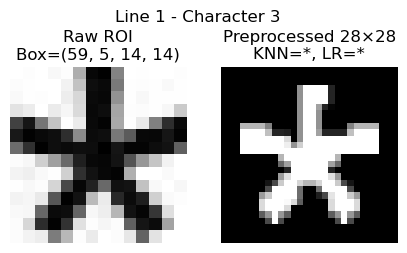

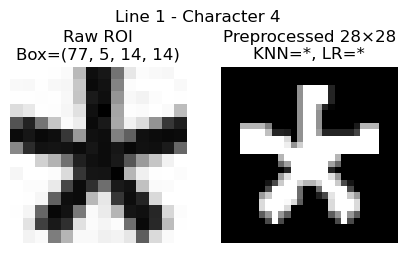

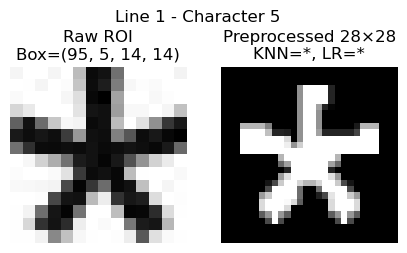

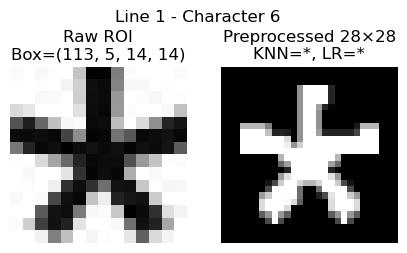

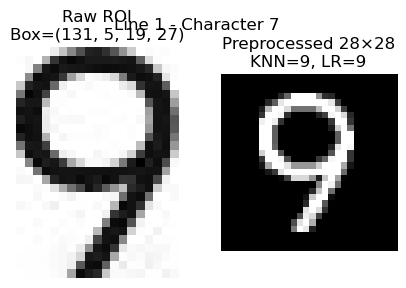

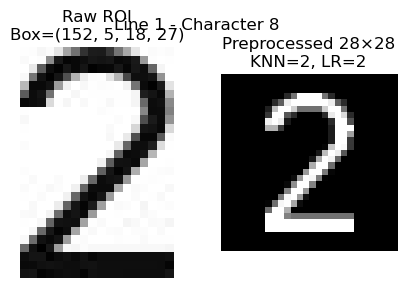

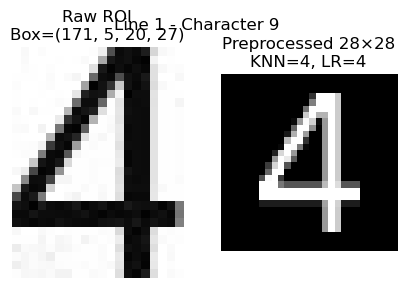


=== Line 0 Bounding Box: (64, 1169, 109, 39) ===
Characters detected in line 0: 6


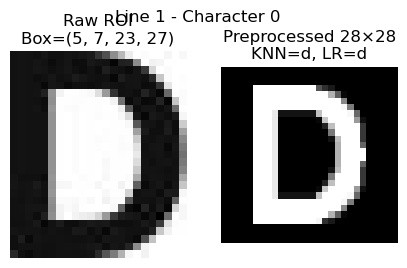

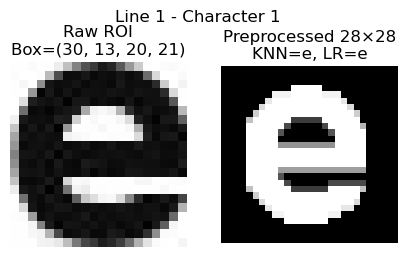

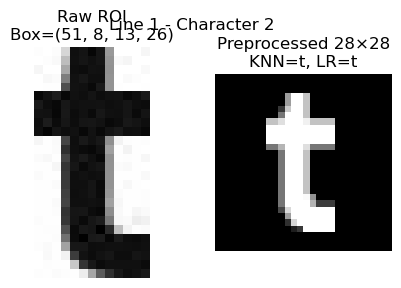

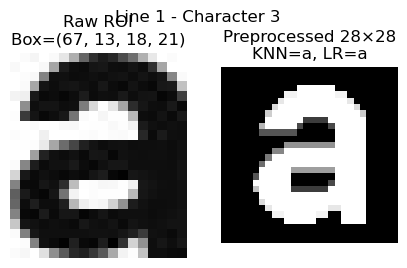

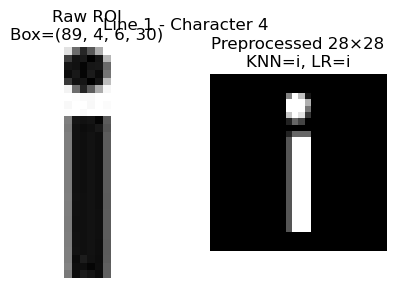

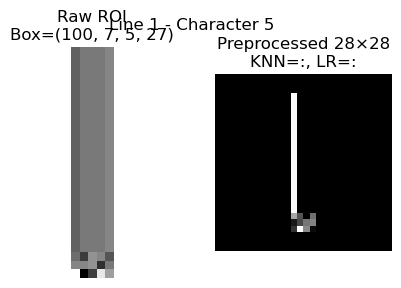


=== Line 1 Bounding Box: (176, 1171, 154, 36) ===
Characters detected in line 1: 8


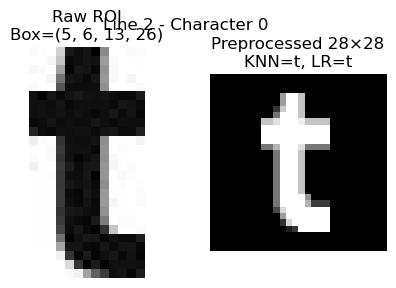

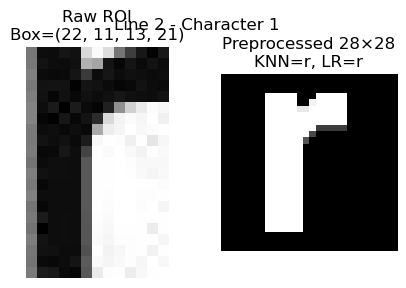

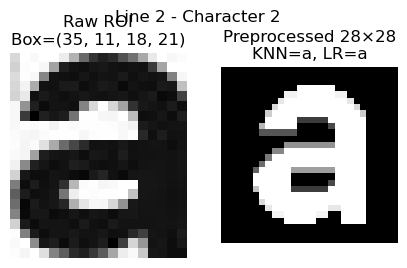

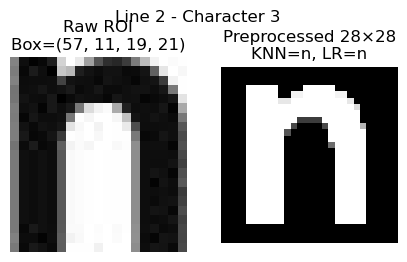

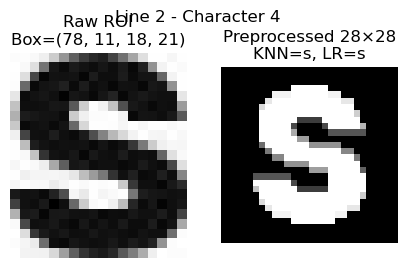

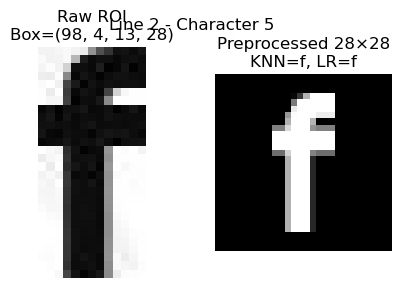

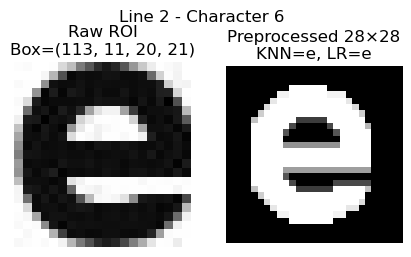

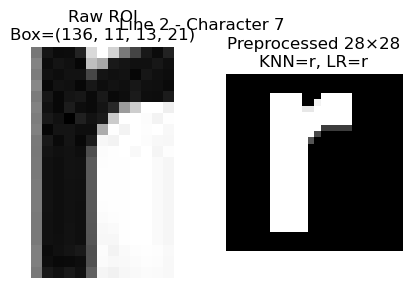


=== Line 0 Bounding Box: (65, 1269, 142, 37) ===
Characters detected in line 0: 7


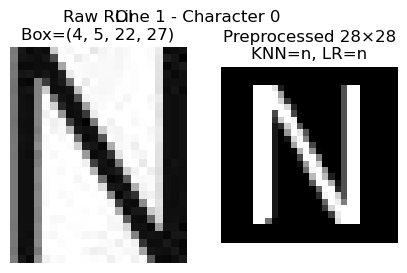

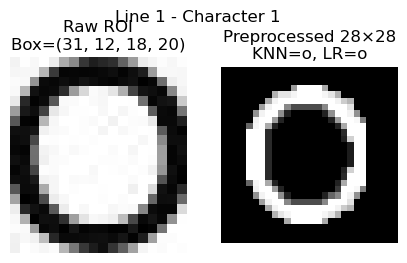

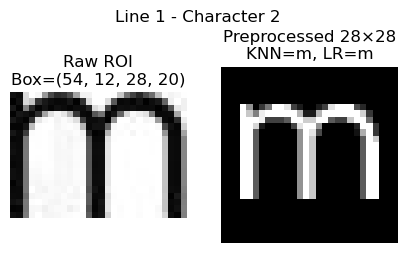

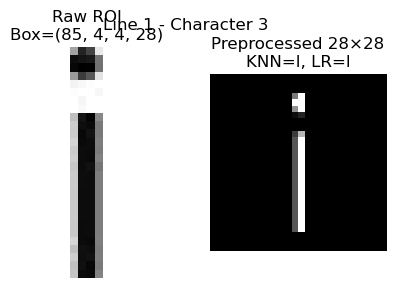

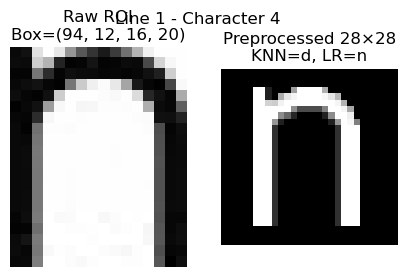

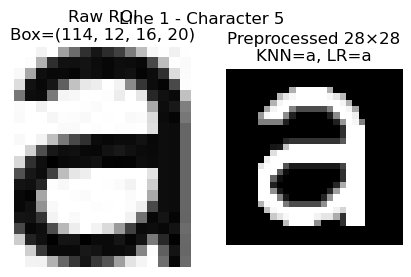

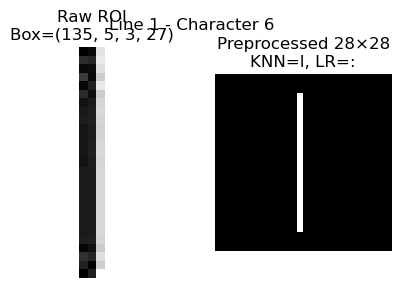


=== Line 1 Bounding Box: (823, 1269, 196, 44) ===
Characters detected in line 1: 9


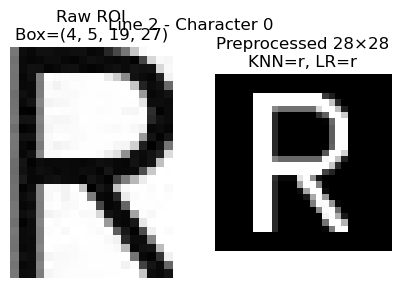

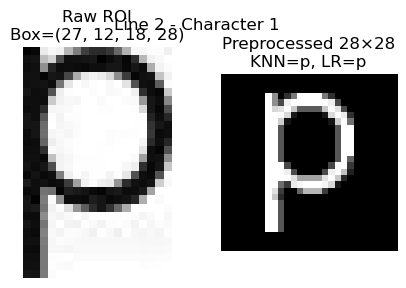

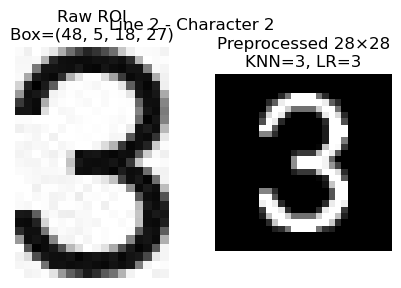

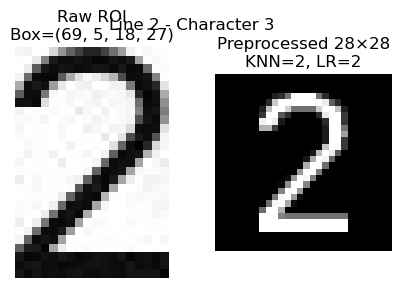

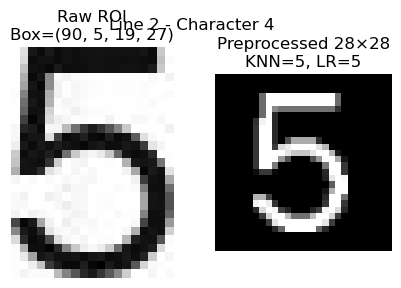

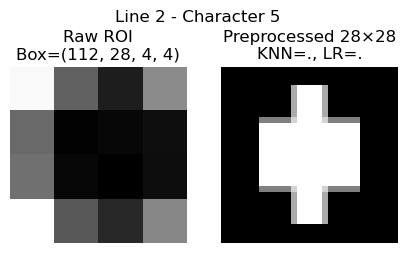

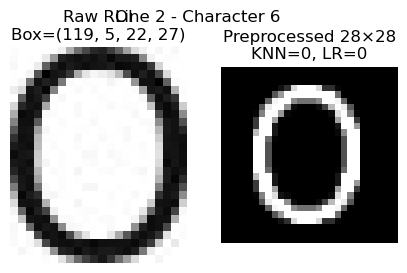

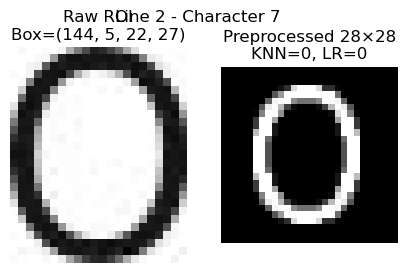

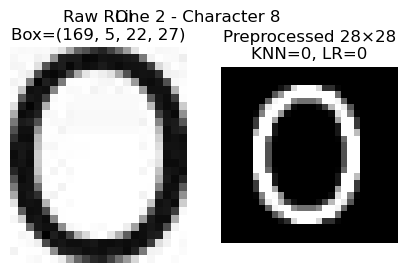


=== Line 0 Bounding Box: (65, 1356, 94, 45) ===
Characters detected in line 0: 5


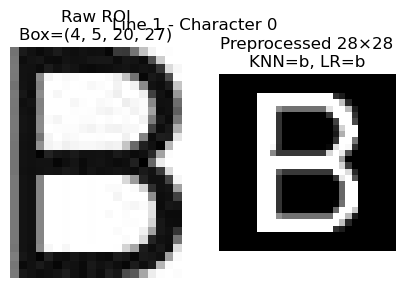

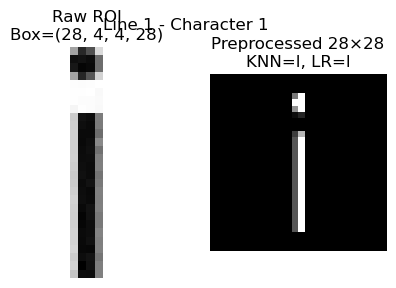

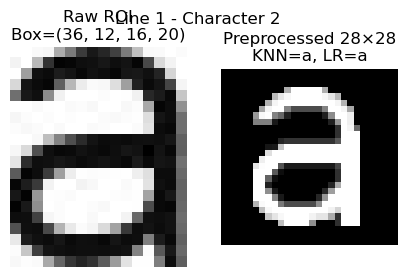

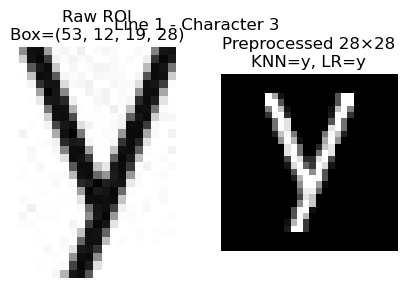

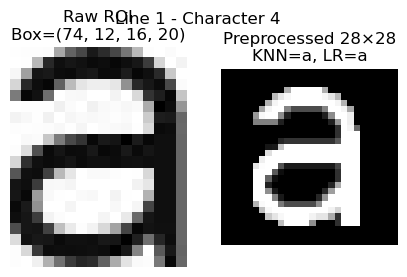


=== Line 1 Bounding Box: (161, 1356, 155, 37) ===
Characters detected in line 1: 9


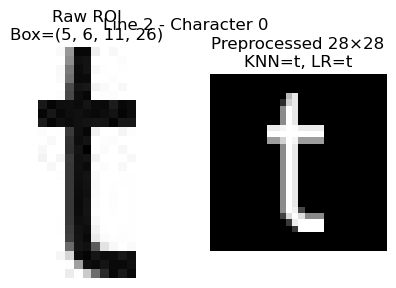

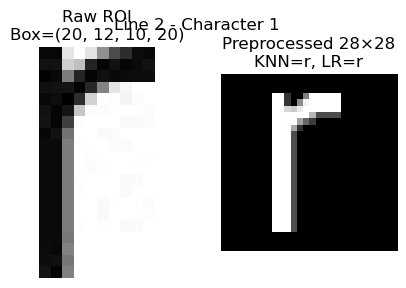

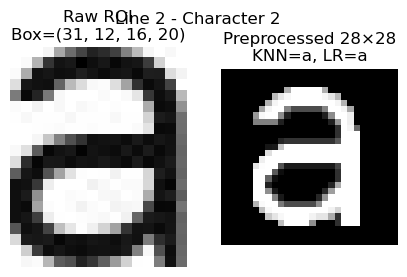

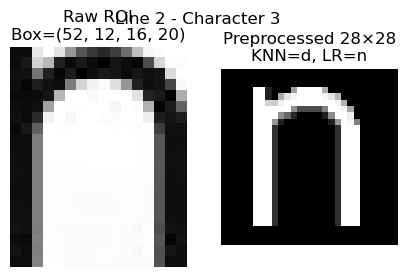

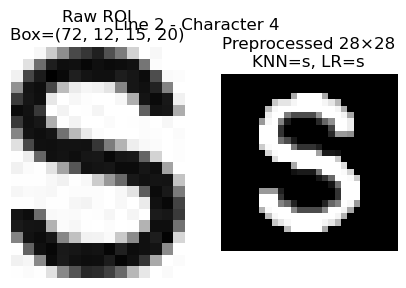

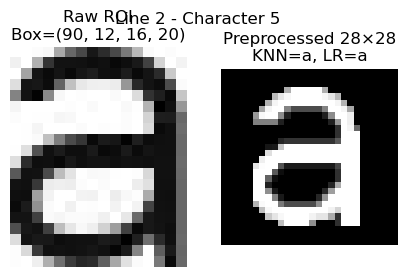

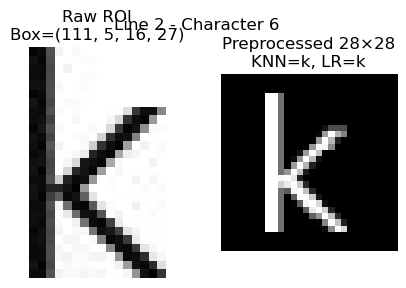

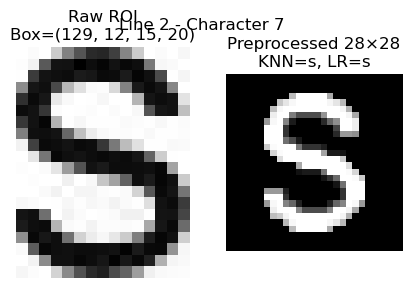

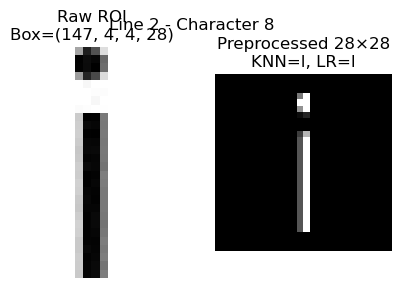


=== Line 2 Bounding Box: (943, 1356, 75, 44) ===
Characters detected in line 2: 3

=== Line 0 Bounding Box: (62, 1494, 86, 37) ===
Characters detected in line 0: 5


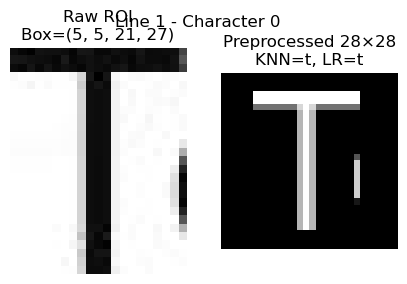

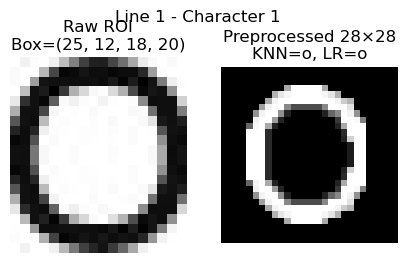

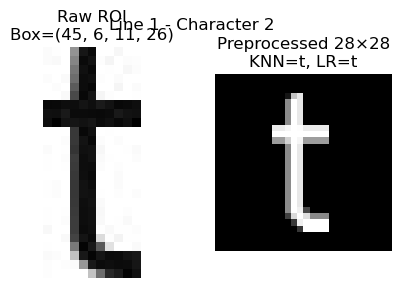

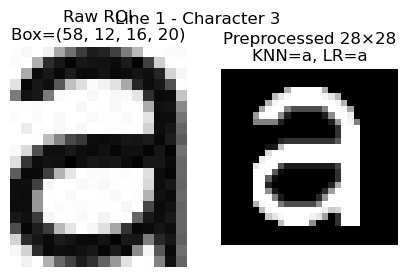

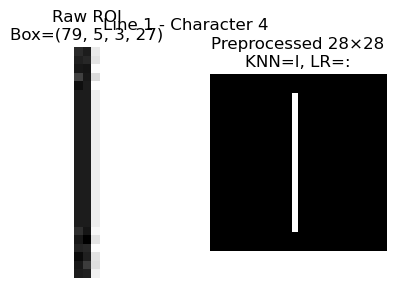


=== Line 1 Bounding Box: (667, 1485, 349, 68) ===
Characters detected in line 1: 9


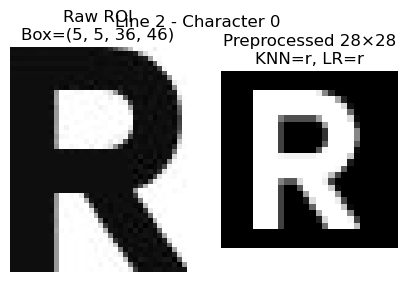

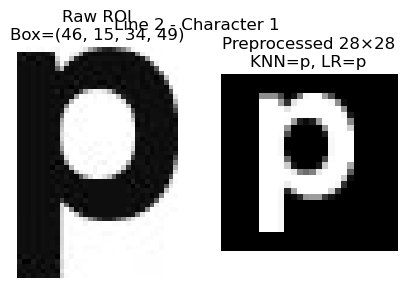

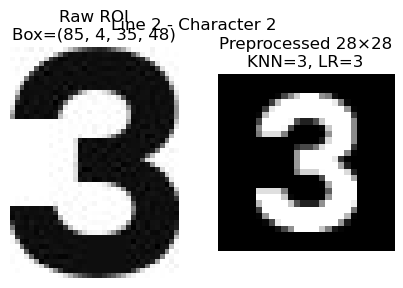

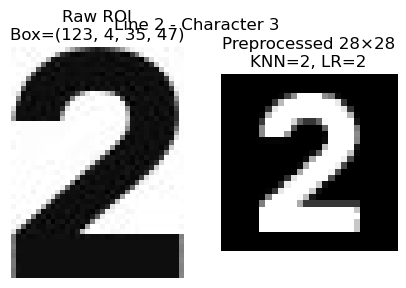

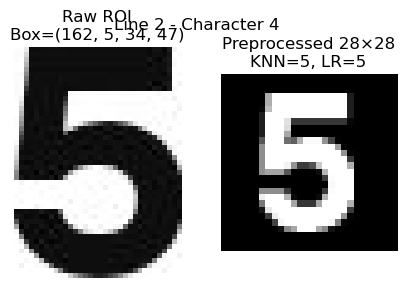

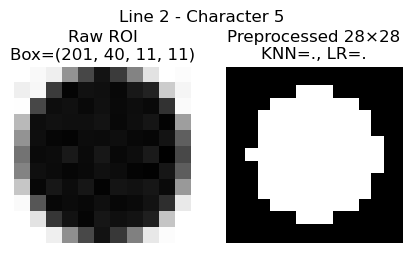

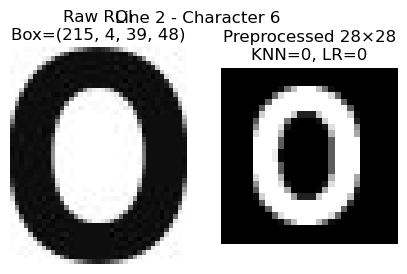

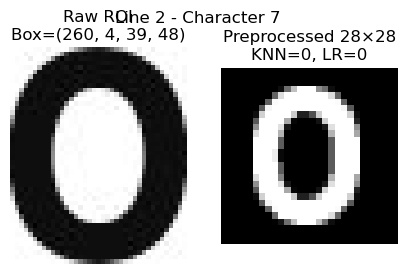

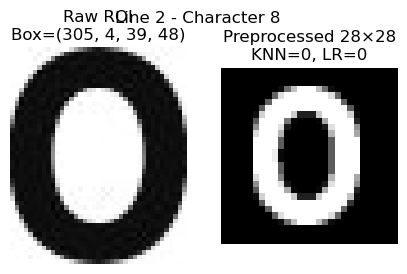

KNN verification
Actual rp325.000 - Expected value: rp14.000
Logistic regression verification
Actual rp325.000 - Expected value: rp14.000

=== VERIFICATION RESULT ===

--- Layout Structure Validation ---
Similarity Score: 75.0%
Threshold       : 65.0%
Status          : PASS
Reason          : Layout structure matches expected template (similarity: 75.0%).

Detailed Scores:
  ✓ num_lines: 100.0%
  ✓ avg_line_height: 100.0%
  ✗ avg_line_width: 0.0%
  ✓ avg_line_gap: 100.0%
  ✓ alignment: 100.0%
  ✓ zone_distribution: 100.0%
  ✗ width_distribution: 0.0%
KNN Verdict     : FAIL
Logistic Verdict: FAIL
FINAL VERDICT   : POTENTIALLY FAKE

--- KNN Field Checks ---
total_amount: expected=rp14.000 | actual=rp325.000 | match=False

--- Logistic Field Checks ---
total_amount: expected=rp14.000 | actual=rp325.000 | match=False


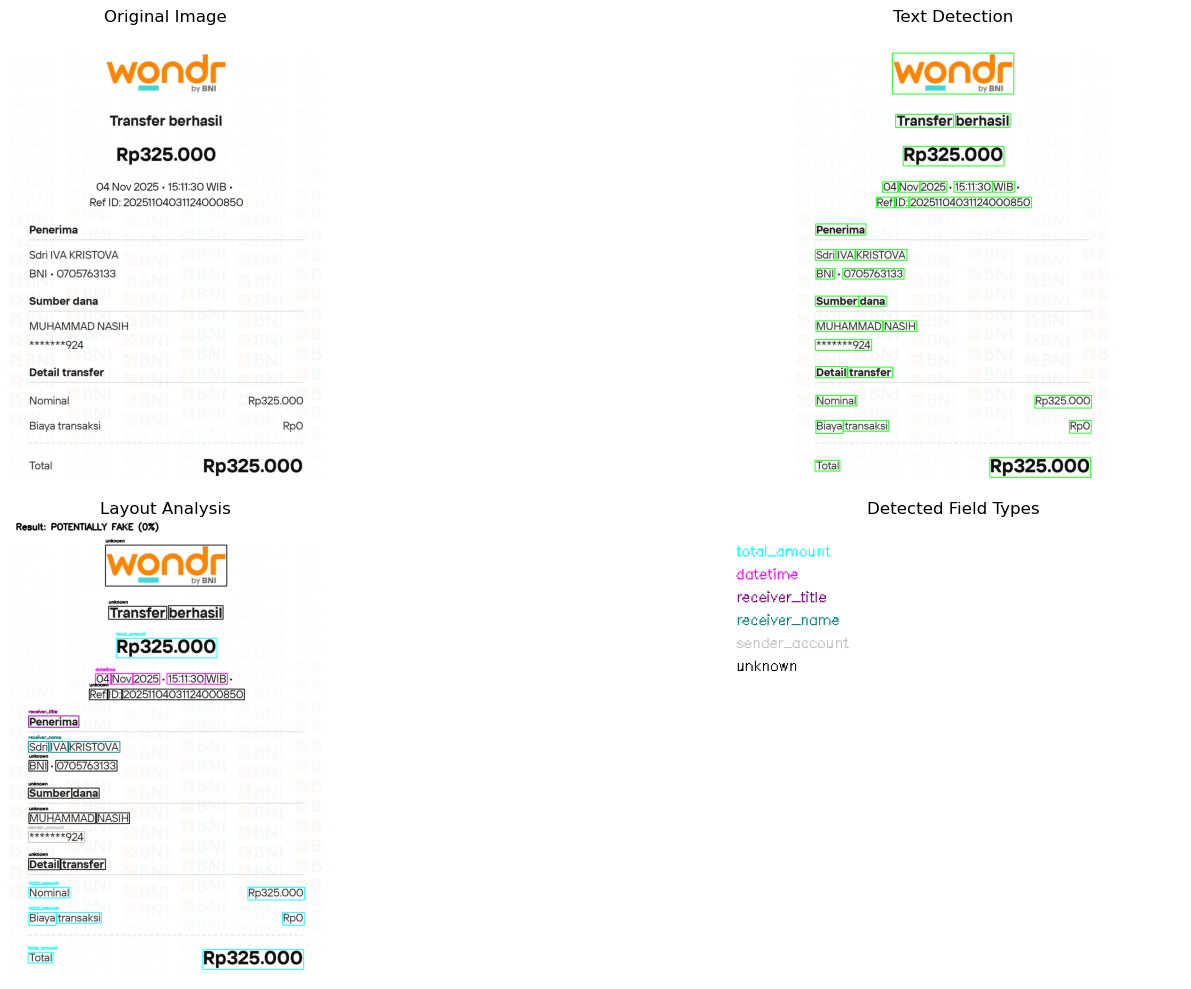


DETAILED LAYOUT ANALYSIS:
Total lines: 15
Line  0:
   KNN     -> unknown         | 'w9n4byur'
   Logistic-> unknown         | 'w2n4bynr'
Line  1:
   KNN     -> unknown         | 'tradsferberhasi1'
   Logistic-> unknown         | 'transferberbasil'
Line  2:
   KNN     -> total_amount    | 'rp325.000'
   Logistic-> total_amount    | 'rp325.000'
Line  3:
   KNN     -> datetime        | '04nov202515:11:30wlb'
   Logistic-> datetime        | '04nov202515:11:30w:b'
Line  4:
   KNN     -> unknown         | 'refld:20251104031124000850'
   Logistic-> unknown         | 'ref:d:20251104031124000850'
Line  5:
   KNN     -> receiver_title  | 'penerima'
   Logistic-> receiver_title  | 'penerima'
Line  6:
   KNN     -> receiver_name   | 'sdrllvarrlstova'
   Logistic-> receiver_name   | 'sdrl:varr:stova'
Line  7:
   KNN     -> unknown         | 'bnl0705763133'
   Logistic-> unknown         | 'bn:0705763133'
Line  8:
   KNN     -> unknown         | 'sumberdana'
   Logistic-> unknown         | 'sumberda

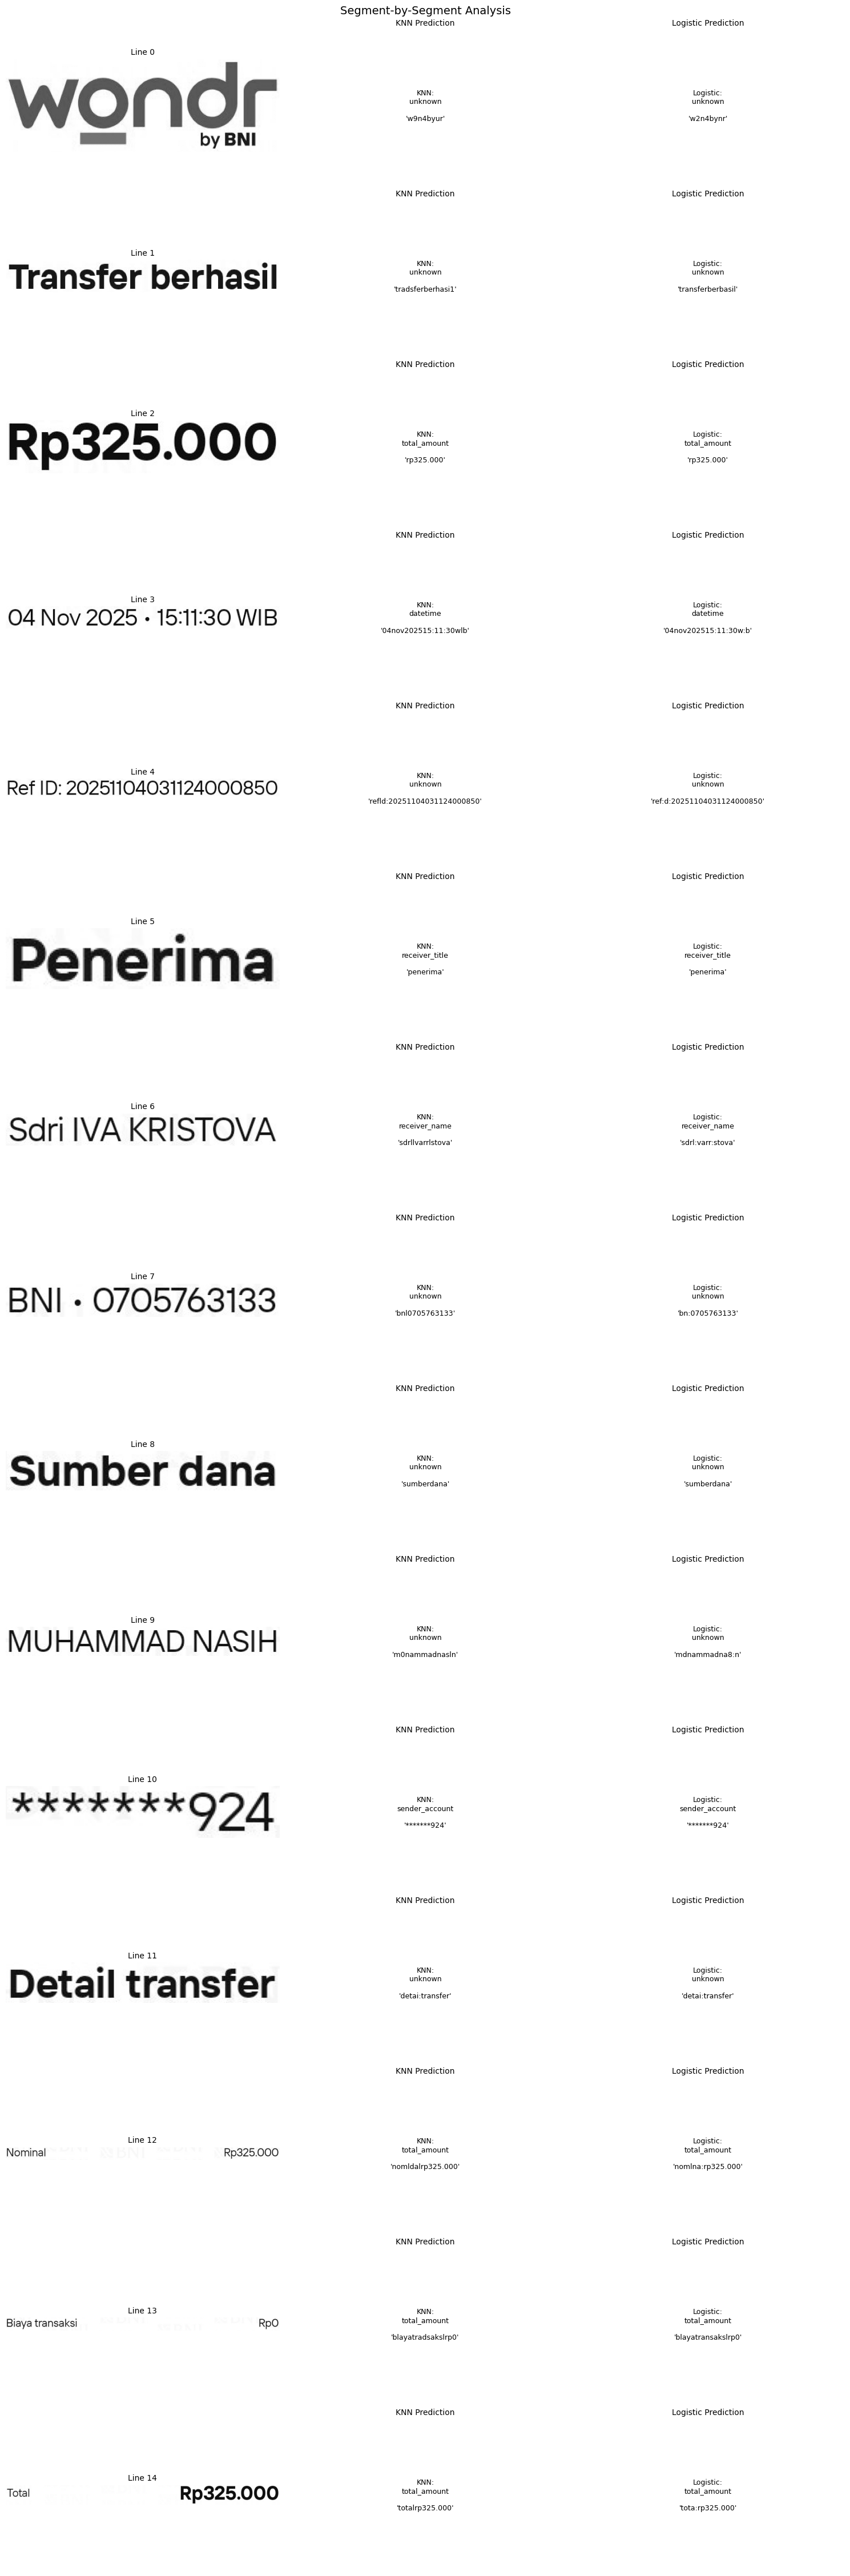

In [ ]:
def main(image_path: str, expected_amount: str) -> None:
    """Test with your actual receipt image"""

    expected_fields = {"total_amount": expected_amount.lower()}

    result, lines_data = layout_aware_receipt_verification(image_path, expected_fields)

    # Check if early detection triggered
    if result.get("early_detection", False):
        print("\n" + "=" * 60)
        print("⚠️  FAKE RECEIPT DETECTED IN EARLY VALIDATION")
        print("=" * 60)
        print("Processing stopped. No need for further OCR analysis.")
        return

    print("\n" + "=" * 60)
    print("DETAILED LAYOUT ANALYSIS:")
    print("=" * 60)
    print(f"Total lines: {len(lines_data)}")
    for line in lines_data:
        print(f"Line {line['line_number']:2d}:")
        print(f"   KNN     -> {line['field_knn']:15} | '{line['text_knn']}'")
        print(f"   Logistic-> {line['field_logistic']:15} | '{line['text_logistic']}'")

    # Add visualization for each segment
    print("\n" + "=" * 60)
    print("VISUALIZING EACH SEGMENT:")
    print("=" * 60)

    # Load the original image for cropping
    image = cv2.imread(image_path)

    if image is None:
        raise Exception("Image is not found!")

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Calculate grid layout
    num_lines = len(lines_data)
    cols = 3  # 3 columns: segment image, KNN text, Logistic text
    rows = num_lines

    fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))

    # Handle single row case
    if rows == 1:
        axes = axes.reshape(1, -1)

    for i, line in enumerate(lines_data):
        # Get bounding box for entire line
        boxes = line["boxes"]
        if not boxes:
            continue

        # Calculate combined bounding box for all boxes in the line
        x_min = min(box[0] for box in boxes)
        y_min = min(box[1] for box in boxes)
        x_max = max(box[0] + box[2] for box in boxes)
        y_max = max(box[1] + box[3] for box in boxes)

        # Extract line ROI
        line_roi = gray[y_min:y_max, x_min:x_max]

        # Display segment image
        axes[i, 0].imshow(line_roi, cmap="gray")
        axes[i, 0].set_title(f"Line {line['line_number']}", fontsize=10)
        axes[i, 0].axis("off")

        # Display KNN prediction
        axes[i, 1].text(
            0.5,
            0.5,
            f"KNN:\n{line['field_knn']}\n\n'{line['text_knn']}'",
            ha="center",
            va="center",
            fontsize=9,
            wrap=True,
        )
        axes[i, 1].set_title("KNN Prediction", fontsize=10)
        axes[i, 1].axis("off")

        # Display Logistic prediction
        axes[i, 2].text(
            0.5,
            0.5,
            f"Logistic:\n{line['field_logistic']}\n\n'{line['text_logistic']}'",
            ha="center",
            va="center",
            fontsize=9,
            wrap=True,
        )
        axes[i, 2].set_title("Logistic Prediction", fontsize=10)
        axes[i, 2].axis("off")

    plt.tight_layout()
    plt.suptitle("Segment-by-Segment Analysis", fontsize=14, y=1.002)
    plt.show()


# Execute
main(image_path="../input/new/template_01.jpg", expected_amount="Rp325.000")  